In [3]:
from __future__ import print_function
import torch

import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import numpy.random as npr
import numpy.linalg  as la
import matplotlib.pyplot as plt

import scipy.linalg
import time
import pickle as pkl
import copy

from google.colab import files


In [4]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
#Assign cuda GPU located at location '0' to a variable
cuda0 = torch.device('cuda:0')
print(cuda0)

1
Tesla P100-PCIE-16GB
cuda:0


# Functions
Functions required to run method.

In [5]:
def policy_gradient(discount, system, num_rollouts=1000, sim_length=50, num_iters=100, learning_rate=0.01):

  # specify the optimizer: 
  # optimizer = torch.optim.SGD(system.parameters(), lr=learning_rate)
  optimizer = torch.optim.Adam(system.parameters(), lr=learning_rate)

  costs = np.zeros(num_iters) 

  tol = 1e-6 # convergence tolerance 
  iterate = 1
  epoch = 0

  # while iterate:
  for epoch in range(num_iters):

      x0 = torch.cuda.FloatTensor(system.nx, num_rollouts).normal_() # initial conds
      x0n = torch.norm(x0,2,0)
      x0 = system.ball_radius*x0/x0n  # on a sphere of radius rho

      optimizer.zero_grad() # zero the buffers for autograd calculation   
      
      loss = system.simulate(discount, x0, sim_length) # simulate the system to compute cost
                    
      loss.backward() # call backprop to compute the gradient of the loss function

      optimizer.step() 

      costs[epoch] = loss.cpu().detach().numpy() # store the cost

      if epoch > 0:
        if costs[epoch-1] - costs[epoch] < tol: # check for convergence
          # print('terminate')
          iterate = 0
      
      # epoch += 1

  print('Final cost ', costs[epoch])

  plt.figure()
  plt.plot(range(num_iters), costs, label='loss')
  plt.xlabel('iteration')
  plt.ylabel('loss')
  plt.legend() 
  plt.show()


def policy_evaluation(discount, system, num_rollouts=1000, sim_length=100):

  x0 = torch.cuda.FloatTensor(system.nx, num_rollouts).normal_() # initial conds
  x0n = torch.norm(x0,2,0)
  x0 = system.ball_radius*x0/x0n  # on a sphere of radius rho

  loss = system.simulate(discount, x0, sim_length) # simulate the system to compute cost

  return loss.cpu().detach().numpy()


def binary_search(gamma0, system, policy_evaluation_function):

  # these settings are consistent with the paper
  target_increase = 2.5;
  eps = 0.2 # tolerance for desired cost increase 

  J_gamma0 = policy_evaluation_function(gamma0)

  # print('Check:')
  # print('J(gamma0) ', J_gamma0)

  # cheat version: check to see if controller stabilizes linearized system
  ABK = system.Alin - system.Blin@system.K.weight.cpu().detach().numpy()

  w,v = np.linalg.eig(ABK)
  sr = np.max(np.absolute(w))

  print('Spectral radius of UNdiscounted closed-loop: ', sr)

  # if sr < 1: # cheat and detect instability with known linear model

  #   print('Controller stabilizes undiscounted linear system')

  #   return 1 # controller is stabilizing for gamma0

  J1 = policy_evaluation_function(1)
  print('Cost on undiscounted system (empirical): ', J1)

  if J1 < target_increase*J_gamma0:

    print('J(1) < ', target_increase, '.J(discount) so good enough')

    return 1 # controller is stabilizing for gamma0


  else:

    print('Controller does NOT stabilize undiscounted system. Doing binary search...')  

    gamma_lwr = gamma0  # lower bound on discount
    gamma_upr = 1  # upper bound on discount

    J_target = target_increase*J_gamma0 # desired cost 

    print('\ttarget cost: ', J_target)

    for attempt in range(100):

      gamma_c = 0.5*(gamma_lwr + gamma_upr)
      Jc = policy_evaluation_function(gamma_c)

      print('\ttrying discount ', gamma_c, ', cost: ', Jc)

      if Jc > (1+eps)*J_target:

        gamma_upr = gamma_c # J(gamma_c) exceeds upper threshold limit

      elif Jc < (1-eps)*J_target:

        gamma_lwr = gamma_c # J(gamma_c) is less than lower threshold limit

      else:

        return gamma_c # J(gamma_c) is within the epsilon threshold


def model_free_stabilization(discount, system, num_rollouts=5000, rollout_length=100, num_policy_gradient_iters=500, learning_rate=0.01, max_iters=30):
  
  discounts = np.zeros(max_iters)
  costs = np.zeros(max_iters)

  if rollout_length < 500:
    rollout_length_eval = 500
  else:
    rollout_length_eval = rollout_length  

  # initialize weight to zero
  system.K.weight = torch.nn.Parameter(torch.zeros((system.nu,system.nx)).cuda())

  tstart = time.perf_counter()

  for iter in range(max_iters):

    print('\nIteration ', iter, ', initial discount ', discount)
    # print('policy parameters')
    # print(system.K.weight.cpu().detach().numpy())

    c = policy_evaluation(discount, 
                          system, 
                          num_rollouts,
                          rollout_length_eval)
       
    print('cost from evaluation: ', c)

    # store progress
    discounts[iter] = discount
    costs[iter] = c

    if discount >= 1:

      print('Stabilizing controller found on iteration ', iter )

      tstop = time.perf_counter()
      print('\ntotal time: ', tstop-tstart)      

      return discounts, costs

    # update controller parameters via policy gradient
    # for interest, compute the cost you'd expect from the optimal controller
    # on the linearized system
    Kopt,Popt = dlqr(np.sqrt(discount)*system.Alin,
                     np.sqrt(discount)*system.Blin,
                     system.Q.cpu().detach().numpy(),
                     system.R.cpu().detach().numpy())
    
    print('Target optimal cost: ', (system.ball_radius**2)*np.trace(Popt/system.nx))

    print('Running policy gradient...')
    controller_params = policy_gradient(discount, 
                                        system, 
                                        num_rollouts, 
                                        rollout_length, 
                                        num_policy_gradient_iters,
                                        learning_rate) 
    
    print('Target optimal controller')
    print(Kopt)

    print('Final controller')
    print(system.K.weight.cpu().detach().numpy())

    ABK = system.Alin - system.Blin@Kopt
    print('Spec rad of UNdiscounted linearized system with OPT controller: ', 
          np.max(np.absolute(np.linalg.eig(system.Alin - system.Blin@Kopt)[0])))

    # Check: evaluate the cost 
    # print('\ncheck: cost evaluation')
    # print('discount: ', discount)
    # print('ball radius', system.ball_radius)

    # c = policy_evaluation(discount, 
    #                       system, 
    #                       num_rollouts,
    #                       rollout_length_eval)
    
    # print('cost from evaluation: ', c)

    policy_eval_fnc = lambda gamma: policy_evaluation(gamma, 
                                                      system, 
                                                      num_rollouts,
                                                      rollout_length_eval)
  
    # update the discount factor via binary search
    discount = binary_search(discount, system, policy_eval_fnc)

  tstop = time.perf_counter()
  print('\ntotal time: ', tstop-tstart)

  return discounts, costs


def dlqr(A,B,Q,R): # optimal control for discrete time LQR

  P = scipy.linalg.solve_discrete_are(A,B,Q,R)

  K = np.linalg.solve(R+B.T@P@B, B.T@P@A)

  return K, P


def compute_roa_ball(discount, system, tol = 0.001, num_rollouts=10000, rollout_length=5000):

  rad_lwr = system.ball_radius
  rad_upr = 0.8

  for attempts in range(50):

    rad = 0.5*(rad_lwr+rad_upr)
    system.ball_radius = rad

    c_rad = policy_evaluation(discount, 
                              system, 
                              num_rollouts,
                              rollout_length)
    
    print('lwr: ', rad_lwr, 'upr: ', rad_upr)
    print('rad: ', rad, 'cost: ', c_rad)

    if (c_rad < np.inf) and not np.isnan(c_rad): # stable

      if np.abs(rad-rad_lwr) < tol: 

        return rad

      rad_lwr = rad # increase the lower bound to current value

    else: # unstable
      rad_upr = rad


  return rad_lwr


def model_free_stabilization_opt(discount, system, num_rollouts=5000, rollout_length=100, num_policy_gradient_iters=500, learning_rate=0.01, max_iters=30):
  
  discounts = np.zeros(max_iters)
  pre_costs = np.zeros(max_iters)
  post_costs = np.zeros(max_iters)
  Kerrors = np.zeros(max_iters)

  if rollout_length < 500:
    rollout_length_eval = 500
  else:
    rollout_length_eval = rollout_length  

  # initialize weight to zero
  system.K.weight = torch.nn.Parameter(torch.zeros((system.nu,system.nx)).cuda())

  tstart = time.perf_counter()

  continue_discount_search = 1
  iter = 0

  while continue_discount_search:

    print('\nIteration ', iter, ', initial discount ', discount)

    c = policy_evaluation(discount, 
                          system, 
                          num_rollouts,
                          rollout_length_eval)
       
    print('pre-cost from evaluation: ', c)

    # store progress
    discounts[iter] = discount
    pre_costs[iter] = c

    if discount >= 1:

      print('Stabilizing controller found on iteration ', iter )

      discount = 1
      continue_discount_search = 0 # terminate the search

      print('Doing the final policy gradient update')
      # increase number of iterations for final optimization
      num_policy_gradient_iters = 250

    # update controller parameters via policy gradient
    Kopt,Popt = dlqr(np.sqrt(discount)*system.Alin,
                     np.sqrt(discount)*system.Blin,
                     system.Q.cpu().detach().numpy(),
                     system.R.cpu().detach().numpy())
    
    print('Target optimal cost: ', (system.ball_radius**2)*np.trace(Popt/system.nx))

    print('Running policy gradient...')
    controller_params = policy_gradient(discount, 
                                        system, 
                                        num_rollouts, 
                                        rollout_length, 
                                        num_policy_gradient_iters,
                                        learning_rate) 
    
    print('Target optimal controller')
    print(Kopt)

    print('Policy gradient controller')
    Kpg = system.K.weight.cpu().detach().numpy()
    print(Kpg)

    # calculate error relative to optimal controller
    Kerrors[iter] = np.linalg.norm(Kopt-Kpg,2)
    print('2-norm of controller error: ', Kerrors[iter])

    ABK = system.Alin - system.Blin@Kopt
    print('Spec rad of UNdiscounted linearized system with OPT controller: ', 
          np.max(np.absolute(np.linalg.eig(system.Alin - system.Blin@Kopt)[0])))

    c = policy_evaluation(discount, 
                          system, 
                          num_rollouts,
                          rollout_length_eval)
       
    print('post-optimization cost from evaluation: ', c)
    post_costs[iter] = c    

    policy_eval_fnc = lambda gamma: policy_evaluation(gamma, 
                                                      system, 
                                                      num_rollouts,
                                                      rollout_length_eval)
  
    # update the discount factor via binary search
    discount = binary_search(discount, system, policy_eval_fnc)

    iter += 1

    if iter == max_iters:
      continue_discount_search = 0

   
  tstop = time.perf_counter()
  print('\ntotal time: ', tstop-tstart)

  return discounts, pre_costs, post_costs, Kerrors






In [6]:

class MyLinearSystem(nn.Module):
    
  def __init__(self, A, B, Q, R, ball_radius):
      
      # super(Net, self).__init__() 
      super(MyLinearSystem, self).__init__() 
      
      nx,nu = B.size()

      self.A = A.cuda()
      self.B = B.cuda()
      self.Q = Q.cuda()
      self.R = R.cuda()

      self.ball_radius = ball_radius
      self.nx = nx
      self.nu = nu

      self.K = nn.Linear(nx,nu,bias=False)

  def transition(self, discount, x, u):

    return np.sqrt(discount)*(self.A@x + self.B@u)

  def stage_cost(self, x, u):

    nx, b = x.size()
    nu = u.size(0)

    cx = torch.bmm(x.T.view(b,1,nx),(self.Q@x).T.view(b,nx,1)) 
    cu = torch.bmm(u.T.view(b,1,nu),(self.R@u).T.view(b,nu,1))    

    return (cx + cu).view(1,b)


  def simulate(self, discount, x, T):

    nx, b = x.size()

    cost = torch.zeros((1,b)).cuda()

    for t in range(T):

      u = -self.K.weight@x
      cost += self.stage_cost(x,u)
      x = self.transition(discount,x,u)

    return torch.sum(cost)/b 

  def plot(self, discount, x, T):

    nx, b = x.size()

    cost = torch.zeros((1,b)).cuda()

    xs = torch.zeros((nx,T))

    for t in range(T):

      xs[:,t] = x[:,0]

      u = self.K.weight@x
      cost += self.stage_cost(x,u)
      x = self.transition(discount,x,u)

    return torch.sum(cost)/(b), xs.cpu().detach().numpy()  

In [7]:
class MyCartPole(nn.Module):
    
  def __init__(self, Q, R, dt, ball_radius):
      
      super(MyCartPole, self).__init__() 
      
      self.Q = Q.cuda()
      self.R = R.cuda()
      self.ball_radius = ball_radius
      self.nx = 4
      self.nu = 1
      self.dt = dt

      self.K = nn.Linear(self.nx,self.nu,bias=False)

  def transition(self, discount, x, u):

    dt = self.dt

    mc = 1
    mp = 1
    g = 1
    l = 1

    th = x[1,:]
    xdot = x[2,:]
    thdot = x[3,:]

    xddot = torch.div(u[0,:] + mp*torch.sin(th)*(-l*torch.pow(thdot,2) + g*torch.cos(th)),
                      mc + mp*torch.pow(torch.sin(th),2)) 

    thddot = torch.div(u[0,:]*torch.cos(th) - mp*l*torch.pow(thdot,2)*torch.cos(th)*torch.sin(th) + (mc+mp)*g*torch.sin(th), 
                      l*(mc + mp*torch.pow(torch.sin(th),2)))

    acc = torch.vstack((xdot,thdot,xddot,thddot))

    return np.sqrt(discount)*(x + dt*acc)

  def stage_cost(self, x, u):

    nx, b = x.size()
    nu = u.size(0)

    cx = torch.bmm(x.T.view(b,1,nx),(self.Q@x).T.view(b,nx,1)) 
    cu = torch.bmm(u.T.view(b,1,nu),(self.R@u).T.view(b,nu,1))    

    return (cx + cu).view(1,b)


  def simulate(self, discount, x, T):

    nx, b = x.size()

    cost = torch.zeros((1,b)).cuda()

    for t in range(T):

      u = -self.K.weight@x
      cost += self.stage_cost(x,u)
      x = self.transition(discount,x,u)

    return torch.sum(cost)/(b)  


  def plot(self, discount, x, T):

    nx, b = x.size()

    cost = torch.zeros((1,b)).cuda()

    xs = torch.zeros((nx,T))

    for t in range(T):

      xs[:,t] = x[:,0]

      u = self.K.weight@x
      cost += self.stage_cost(x,u)
      x = self.transition(discount,x,u)

    return torch.sum(cost)/(b), xs.cpu().detach().numpy()      


def linearized_cartpole(dt):

  # temporary - should linearize the nonlinear
  mc = 1
  mp = 1
  g = 1
  l = 1

  M = np.array([[mc+mp, -mp*l],
                [-mp*l,  mp*l**2]])

  dtdq = np.array([[0, 0],
                  [0, mp*g*l]])

  # One actuator
  B_ = np.array([[1],
                [0]])

  # two actuators
  # B_ = np.array([[1,0],
  #                [0,1]])

  nu = B_.shape[1]

  A1 = np.hstack((np.zeros((2,2)), np.eye(2)))
  A2 = np.hstack((np.linalg.solve(M,dtdq), np.zeros((2,2))))
  Act = np.vstack((A1,A2))
  Bct = np.vstack((np.zeros((2,nu)), np.linalg.solve(M,B_).reshape(2,nu)))

  Alcp = np.eye(4) + dt*Act
  Blcp = dt*Bct

  return Alcp, Blcp

dt = 0.05

Alcp, Blcp = linearized_cartpole(dt)

nx = Alcp.shape[0]
nu = Blcp.shape[1]

Q = dt*np.diag([1.0,1,1,1])
R = dt*np.eye(nu)

print('nx: ', nx, ', nu: ', nu)

print('A')
print(Alcp)

print('B')
print(Blcp)

print('Q')
print(Q)

print('R')
print(R)

Alcp_cuda = torch.from_numpy(Alcp).float().cuda()
Blcp_cuda = torch.from_numpy(Blcp).float().cuda()

Q_cuda = torch.from_numpy(Q).float().cuda()
R_cuda = torch.from_numpy(R).float().cuda()

# Qcuda = torch.diag(torch.tensor([1.0,1.0,1,1])).cuda()
# Rcuda = torch.diag(torch.tensor([1.0])).cuda()




nx:  4 , nu:  1
A
[[1.   0.   0.05 0.  ]
 [0.   1.   0.   0.05]
 [0.   0.05 1.   0.  ]
 [0.   0.1  0.   1.  ]]
B
[[0.  ]
 [0.  ]
 [0.05]
 [0.05]]
Q
[[0.05 0.   0.   0.  ]
 [0.   0.05 0.   0.  ]
 [0.   0.   0.05 0.  ]
 [0.   0.   0.   0.05]]
R
[[0.05]]


# Demo

Stabilize the nonlinear cartpole using disocunt annealing.

Initial discount factor  0.7715471166835529

Iteration  0 , initial discount  0.7715471166835529
pre-cost from evaluation:  0.002694163
Target optimal cost:  0.00258144554885547
Running policy gradient...
Final cost  0.0025923277717083693


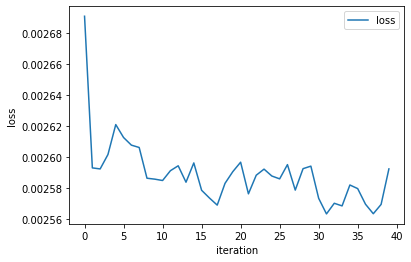

Target optimal controller
[[0.02692094 0.15734008 0.17111459 0.20121149]]
Policy gradient controller
[[0.02845678 0.15908845 0.17955528 0.21544787]]
2-norm of controller error:  0.016713333437920936
Spec rad of UNdiscounted linearized system with OPT controller:  1.0615300805007644
post-optimization cost from evaluation:  0.0025793659
Spectral radius of UNdiscounted closed-loop:  1.0611412719357636
Cost on undiscounted system (empirical):  83579.336
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.006479803705587983
	trying discount  0.8857735583417765 , cost:  0.048780404
	trying discount  0.8286603375126647 , cost:  0.00420894
	trying discount  0.8572169479272206 , cost:  0.0068730377

Iteration  1 , initial discount  0.8572169479272206
pre-cost from evaluation:  0.0067915325
Target optimal cost:  0.005817766070765063
Running policy gradient...
Final cost  0.005776253528892994


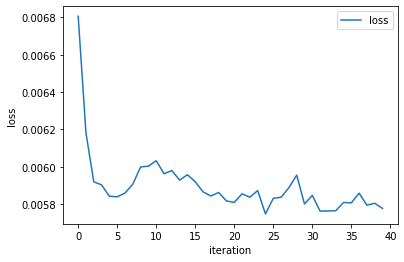

Target optimal controller
[[0.07156047 0.5578161  0.28440931 0.49647784]]
Policy gradient controller
[[0.08515819 0.6051626  0.31207177 0.5384351 ]]
2-norm of controller error:  0.07037197301747235
Spec rad of UNdiscounted linearized system with OPT controller:  1.0491516800608056
post-optimization cost from evaluation:  0.005857932
Spectral radius of UNdiscounted closed-loop:  1.0478344172088048
Cost on undiscounted system (empirical):  192309.25
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.014513963833451271
	trying discount  0.9286084739636102 , cost:  13.7967
	trying discount  0.8929127109454154 , cost:  0.013607434

Iteration  2 , initial discount  0.8929127109454154
pre-cost from evaluation:  0.0137468185
Target optimal cost:  0.010851948563851235
Running policy gradient...
Final cost  0.01098284125328064


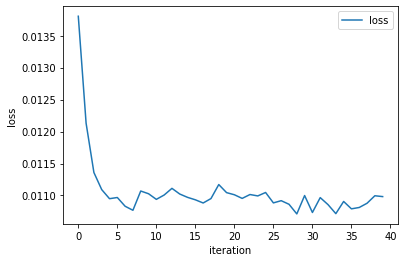

Target optimal controller
[[0.10047046 1.12960651 0.30953934 0.90391817]]
Policy gradient controller
[[0.12207219 1.0548538  0.27221906 0.9629101 ]]
2-norm of controller error:  0.10453447221618223
Spec rad of UNdiscounted linearized system with OPT controller:  1.0360205637729063
post-optimization cost from evaluation:  0.010947231
Spectral radius of UNdiscounted closed-loop:  1.0363762259920917
Cost on undiscounted system (empirical):  78605.31
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.02710331231355667
	trying discount  0.9464563554727077 , cost:  50.36004
	trying discount  0.9196845332090615 , cost:  0.029331423

Iteration  3 , initial discount  0.9196845332090615
pre-cost from evaluation:  0.029384209
Target optimal cost:  0.01976577989152489
Running policy gradient...
Final cost  0.019562505185604095


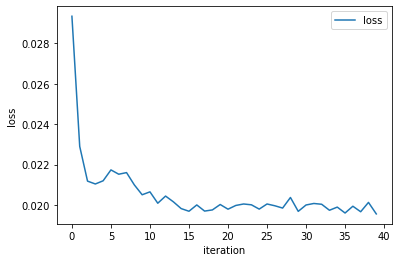

Target optimal controller
[[0.1047231  1.91664053 0.22193753 1.48940264]]
Policy gradient controller
[[0.14757842 2.0066085  0.23467652 1.7647285 ]]
2-norm of controller error:  0.29308266209694406
Spec rad of UNdiscounted linearized system with OPT controller:  1.022636922674921
post-optimization cost from evaluation:  0.019543052
Spectral radius of UNdiscounted closed-loop:  1.0224580343494596
Cost on undiscounted system (empirical):  185383.7
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.049379849806427956
	trying discount  0.9598422666045308 , cost:  1.0336317
	trying discount  0.9397633999067961 , cost:  0.041139353

Iteration  4 , initial discount  0.9397633999067961
pre-cost from evaluation:  0.04229968
Target optimal cost:  0.034057551958979006
Running policy gradient...
Final cost  0.033802635967731476


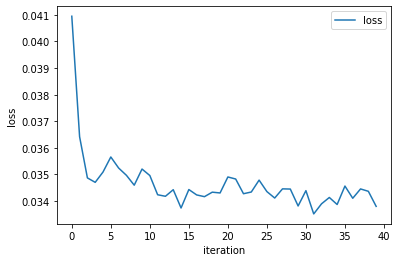

Target optimal controller
[[ 0.06613945  2.82031465 -0.02225431  2.20999893]]
Policy gradient controller
[[ 0.05638082  2.9742866  -0.00772194  2.3574393 ]]
2-norm of controller error:  0.2138981663335667
Spec rad of UNdiscounted linearized system with OPT controller:  1.0105116335655304
post-optimization cost from evaluation:  0.034246773
Spectral radius of UNdiscounted closed-loop:  1.0095210032804038
Cost on undiscounted system (empirical):  5563.857
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.08457564748823643
	trying discount  0.9698816999533981 , cost:  0.20420063
	trying discount  0.9548225499300971 , cost:  0.06208873
	trying discount  0.9623521249417476 , cost:  0.09879121

Iteration  5 , initial discount  0.9623521249417476
pre-cost from evaluation:  0.09929259
Target optimal cost:  0.07033469275514663
Running policy gradient...
Final cost  0.07027139514684677


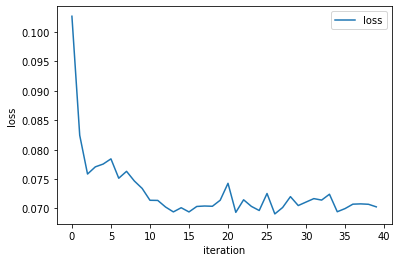

Target optimal controller
[[-0.08868157  4.3848882  -0.71934278  3.56471543]]
Policy gradient controller
[[-0.11304328  4.4762     -0.7799087   3.6825273 ]]
2-norm of controller error:  0.1627243833625815
Spec rad of UNdiscounted linearized system with OPT controller:  0.9875337159191795
post-optimization cost from evaluation:  0.07031313
Spectral radius of UNdiscounted closed-loop:  0.9878519931085958
Cost on undiscounted system (empirical):  0.72606534
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.1773805357515812
	trying discount  0.9811760624708739 , cost:  0.16384514

Iteration  6 , initial discount  0.9811760624708739
pre-cost from evaluation:  0.16106473
Target optimal cost:  0.13376863000009123
Running policy gradient...
Final cost  0.13287733495235443


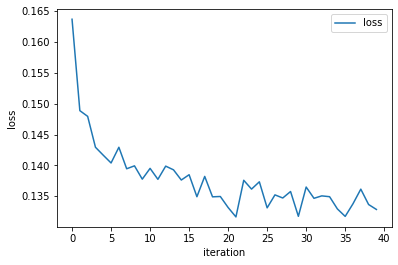

Target optimal controller
[[-0.3796227   6.29818635 -1.85288946  5.33680568]]
Policy gradient controller
[[-0.3369981  5.9158745 -1.6226461  4.5861917]]
2-norm of controller error:  0.8743069471606424
Spec rad of UNdiscounted linearized system with OPT controller:  0.9817328196846081
post-optimization cost from evaluation:  0.13685256
Spectral radius of UNdiscounted closed-loop:  0.9844127022338093
Cost on undiscounted system (empirical):  0.31123734
J(1) <  2.5 .J(discount) so good enough

Iteration  7 , initial discount  1
pre-cost from evaluation:  0.3041709
Stabilizing controller found on iteration  7
Doing the final policy gradient update
Target optimal cost:  0.251155297638222
Running policy gradient...
Final cost  0.24738739430904388


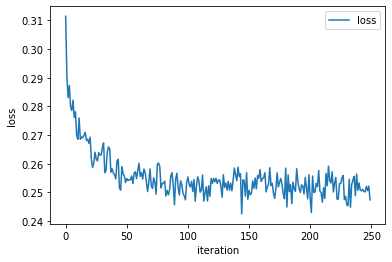

Target optimal controller
[[-0.89970166  8.87862239 -3.65393646  7.835545  ]]
Policy gradient controller
[[-0.8864679  8.800421  -3.5997767  7.729887 ]]
2-norm of controller error:  0.14278484698723157
Spec rad of UNdiscounted linearized system with OPT controller:  0.9732870857688721
post-optimization cost from evaluation:  0.2511924
Spectral radius of UNdiscounted closed-loop:  0.9738423324391726
Cost on undiscounted system (empirical):  0.25173923
J(1) <  2.5 .J(discount) so good enough

total time:  425.232207049


In [8]:
# stabilize nonlinear cartpole

ball_radius = 0.1
cp = MyCartPole(Q_cuda, R_cuda, dt, ball_radius).cuda()

# hack: add the linearization
cp.Alin = Alcp
cp.Blin = Blcp

# use linearization for initial discount
discount = 0.9/(np.linalg.norm(Alcp,2)**2)
print('Initial discount factor ', discount)

d,p_c,c_p,k = model_free_stabilization_opt(discount, 
                         cp,
                         rollout_length=400,
                         num_policy_gradient_iters=40,
                         learning_rate=0.01/ball_radius,
                         max_iters=20) 

# Experiments

## ROA of optimal controller

Compute the region of attraction (ROA) of the optimal controller for the linearized system.

In [ ]:
# test policy evaluation on nonlinear pendulum 
discount = 1

print('discount: ', discount)

cp = MyCartPole(Q_cuda, R_cuda, dt, ball_radius = 0.5).cuda()

K,P = dlqr(np.sqrt(discount)*Alcp,np.sqrt(discount)*Blcp,Q,R)

K_cuda = torch.from_numpy(K).float().cuda() 
cp.K.weight = torch.nn.Parameter(K_cuda)

print('Controller:')
print(K)

roa = compute_roa_ball(discount, cp, 0.001)

print(roa)


discount:  1
Controller:
[[-19.7   83.47 -60.28  81.08]]
lwr:  0.5 upr:  0.8
rad:  0.65 cost:  nan
lwr:  0.5 upr:  0.65
rad:  0.575 cost:  nan
lwr:  0.5 upr:  0.575
rad:  0.5375 cost:  nan
lwr:  0.5 upr:  0.5375
rad:  0.51875 cost:  nan
lwr:  0.5 upr:  0.51875
rad:  0.509375 cost:  nan
lwr:  0.5 upr:  0.509375
rad:  0.5046875 cost:  78.17535
lwr:  0.5046875 upr:  0.509375
rad:  0.50703125 cost:  nan
lwr:  0.5046875 upr:  0.50703125
rad:  0.505859375 cost:  78.92484
lwr:  0.505859375 upr:  0.50703125
rad:  0.5064453125 cost:  nan
lwr:  0.505859375 upr:  0.5064453125
rad:  0.50615234375 cost:  nan
lwr:  0.505859375 upr:  0.50615234375
rad:  0.506005859375 cost:  80.78875
0.506005859375


## Different ball radii

Reproduce results from Table 1 of the paper.

**Warning**: this will take a **long** time to execute. 
To see a demonstration of the method, best run the demo above. 

Sample time:  0.05
Initial discount factor  0.7715471166835529

---------------------------
Ball radius:  0.1  , rep:  0

Iteration  0 , initial discount  0.7715471166835529
pre-cost from evaluation:  0.0026756357
Target optimal cost:  0.00258144554885547
Running policy gradient...
Final cost  0.002582376589998603


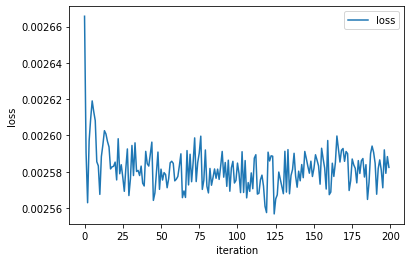

Target optimal controller
[[0.02692094 0.15734008 0.17111459 0.20121149]]
Policy gradient controller
[[0.02691951 0.15627311 0.17102677 0.20105425]]
2-norm of controller error:  0.0010820590853434899
Spec rad of UNdiscounted linearized system with OPT controller:  1.0615300805007644
post-optimization cost from evaluation:  0.0025933497
Spectral radius of UNdiscounted closed-loop:  1.0615518863577957
Cost on undiscounted system (empirical):  2582218.8
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.006464723264798522
	trying discount  0.8857735583417765 , cost:  0.077808686
	trying discount  0.8286603375126647 , cost:  0.0042047333
	trying discount  0.8572169479272206 , cost:  0.0067672958

Iteration  1 , initial discount  0.8572169479272206
pre-cost from evaluation:  0.006972514
Target optimal cost:  0.005817766070765063
Running policy gradient...
Final cost  0.0057623726315796375


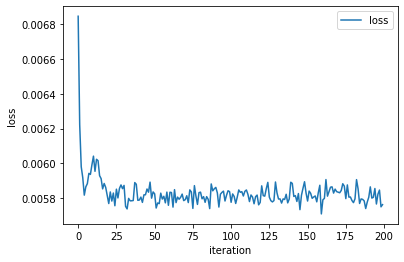

Target optimal controller
[[0.07156047 0.5578161  0.28440931 0.49647784]]
Policy gradient controller
[[0.07153494 0.55449855 0.28435197 0.49628025]]
2-norm of controller error:  0.003324014752184316
Spec rad of UNdiscounted linearized system with OPT controller:  1.0491516800608056
post-optimization cost from evaluation:  0.0058356905
Spectral radius of UNdiscounted closed-loop:  1.0492066431837987
Cost on undiscounted system (empirical):  4801495.0
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.014576332177966833
	trying discount  0.9286084739636102 , cost:  115.122406
	trying discount  0.8929127109454154 , cost:  0.014458734

Iteration  2 , initial discount  0.8929127109454154
pre-cost from evaluation:  0.014891013
Target optimal cost:  0.010851948563851235
Running policy gradient...
Final cost  0.010927681811153889


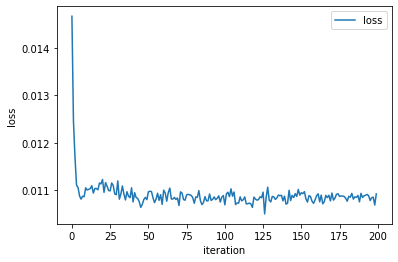

Target optimal controller
[[0.10047046 1.12960651 0.30953934 0.90391817]]
Policy gradient controller
[[0.09984279 1.1250129  0.30885723 0.9032636 ]]
2-norm of controller error:  0.004731721775487065
Spec rad of UNdiscounted linearized system with OPT controller:  1.0360205637729063
post-optimization cost from evaluation:  0.010809742
Spectral radius of UNdiscounted closed-loop:  1.0360738283992368
Cost on undiscounted system (empirical):  5397776.5
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.027392231859266758
	trying discount  0.9464563554727077 , cost:  1582.0586
	trying discount  0.9196845332090615 , cost:  0.028874291

Iteration  3 , initial discount  0.9196845332090615
pre-cost from evaluation:  0.029132424
Target optimal cost:  0.01976577989152489
Running policy gradient...
Final cost  0.01982920989394188


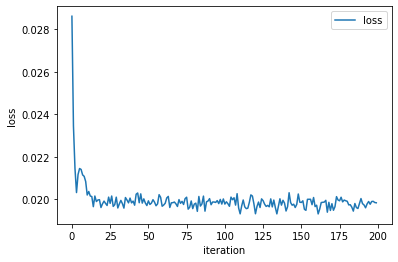

Target optimal controller
[[0.1047231  1.91664053 0.22193753 1.48940264]]
Policy gradient controller
[[0.10416348 1.9118416  0.22110943 1.488867  ]]
2-norm of controller error:  0.004931048431082408
Spec rad of UNdiscounted linearized system with OPT controller:  1.022636922674921
post-optimization cost from evaluation:  0.019951696
Spectral radius of UNdiscounted closed-loop:  1.0226488532531732
Cost on undiscounted system (empirical):  17242306.0
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.04924928769469261
	trying discount  0.9598422666045308 , cost:  10.6121235
	trying discount  0.9397633999067961 , cost:  0.043140415

Iteration  4 , initial discount  0.9397633999067961
pre-cost from evaluation:  0.04314596
Target optimal cost:  0.034057551958979006
Running policy gradient...
Final cost  0.03441702201962471


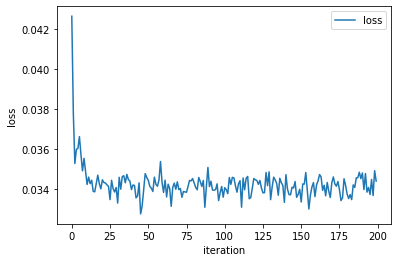

Target optimal controller
[[ 0.06613945  2.82031465 -0.02225431  2.20999893]]
Policy gradient controller
[[ 0.0659705   2.816603   -0.02242629  2.211147  ]]
2-norm of controller error:  0.0038926999632117073
Spec rad of UNdiscounted linearized system with OPT controller:  1.0105116335655304
post-optimization cost from evaluation:  0.034487717
Spectral radius of UNdiscounted closed-loop:  1.0105086744148981
Cost on undiscounted system (empirical):  nan
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.08465435355901718
	trying discount  0.9698816999533981 , cost:  0.23602585
	trying discount  0.9548225499300971 , cost:  0.06345942
	trying discount  0.9623521249417476 , cost:  0.10110048

Iteration  5 , initial discount  0.9623521249417476
pre-cost from evaluation:  0.10395982
Target optimal cost:  0.07033469275514663
Running policy gradient...
Final cost  0.0719359815120697


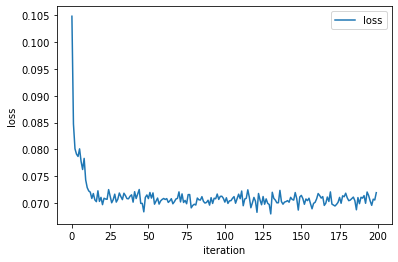

Target optimal controller
[[-0.08868157  4.3848882  -0.71934278  3.56471543]]
Policy gradient controller
[[-0.08867092  4.382739   -0.71952456  3.5687819 ]]
2-norm of controller error:  0.0046030110997531196
Spec rad of UNdiscounted linearized system with OPT controller:  0.9875337159191795
post-optimization cost from evaluation:  0.07005228
Spectral radius of UNdiscounted closed-loop:  0.9874401809703695
Cost on undiscounted system (empirical):  0.85773164
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.17217829823493958
	trying discount  0.9811760624708739 , cost:  0.1676372

Iteration  6 , initial discount  0.9811760624708739
pre-cost from evaluation:  0.17045282
Target optimal cost:  0.13376863000009123
Running policy gradient...
Final cost  0.1347072422504425


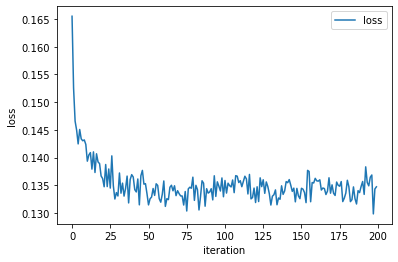

Target optimal controller
[[-0.3796227   6.29818635 -1.85288946  5.33680568]]
Policy gradient controller
[[-0.37912586  6.295506   -1.8532506   5.340707  ]]
2-norm of controller error:  0.00477289504193445
Spec rad of UNdiscounted linearized system with OPT controller:  0.9817328196846081
post-optimization cost from evaluation:  0.1370826
Spectral radius of UNdiscounted closed-loop:  0.9816385594775113
Cost on undiscounted system (empirical):  0.30862653
J(1) <  2.5 .J(discount) so good enough

Iteration  7 , initial discount  1
pre-cost from evaluation:  0.31310916
Stabilizing controller found on iteration  7
Doing the final policy gradient update
Target optimal cost:  0.251155297638222
Running policy gradient...
Final cost  0.2536230981349945


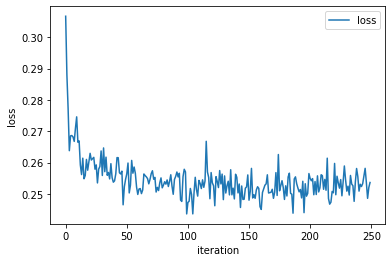

Target optimal controller
[[-0.89970166  8.87862239 -3.65393646  7.835545  ]]
Policy gradient controller
[[-0.89026886  8.825819   -3.6158588   7.7632585 ]]
2-norm of controller error:  0.09773651405388792
Spec rad of UNdiscounted linearized system with OPT controller:  0.9732870857688721
post-optimization cost from evaluation:  0.2511216
Spectral radius of UNdiscounted closed-loop:  0.973712580676193
Cost on undiscounted system (empirical):  0.25429535
J(1) <  2.5 .J(discount) so good enough

total time:  3382.468857823
lwr:  0.1 upr:  0.8
rad:  0.45 cost:  5.441578
lwr:  0.45 upr:  0.8
rad:  0.625 cost:  11.892475
lwr:  0.625 upr:  0.8
rad:  0.7125 cost:  nan
lwr:  0.625 upr:  0.7125
rad:  0.66875 cost:  14.392059
lwr:  0.66875 upr:  0.7125
rad:  0.690625 cost:  16.035192
lwr:  0.690625 upr:  0.7125
rad:  0.7015625000000001 cost:  16.641125
lwr:  0.7015625000000001 upr:  0.7125
rad:  0.70703125 cost:  nan
lwr:  0.7015625000000001 upr:  0.70703125
rad:  0.704296875 cost:  nan
lwr:  0.

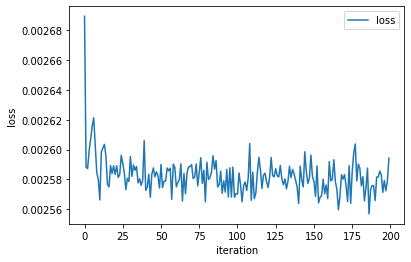

Target optimal controller
[[0.02692094 0.15734008 0.17111459 0.20121149]]
Policy gradient controller
[[0.02692646 0.15626933 0.17103827 0.20105872]]
2-norm of controller error:  0.0010842956882417694
Spec rad of UNdiscounted linearized system with OPT controller:  1.0615300805007644
post-optimization cost from evaluation:  0.002581851
Spectral radius of UNdiscounted closed-loop:  1.0615517368433691
Cost on undiscounted system (empirical):  2588849.0
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.006444612517952919
	trying discount  0.8857735583417765 , cost:  0.07607389
	trying discount  0.8286603375126647 , cost:  0.0042140004
	trying discount  0.8572169479272206 , cost:  0.006866503

Iteration  1 , initial discount  0.8572169479272206
pre-cost from evaluation:  0.006895148
Target optimal cost:  0.005817766070765063
Running policy gradient...
Final cost  0.005756433587521315


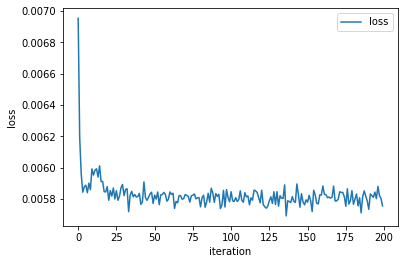

Target optimal controller
[[0.07156047 0.5578161  0.28440931 0.49647784]]
Policy gradient controller
[[0.07147553 0.5544926  0.28430435 0.4962804 ]]
2-norm of controller error:  0.003332100167546878
Spec rad of UNdiscounted linearized system with OPT controller:  1.0491516800608056
post-optimization cost from evaluation:  0.0058170026
Spectral radius of UNdiscounted closed-loop:  1.049206680132993
Cost on undiscounted system (empirical):  4820428.5
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.014434957411140203
	trying discount  0.9286084739636102 , cost:  114.79222
	trying discount  0.8929127109454154 , cost:  0.014748472

Iteration  2 , initial discount  0.8929127109454154
pre-cost from evaluation:  0.014578079
Target optimal cost:  0.010851948563851235
Running policy gradient...
Final cost  0.010638662613928318


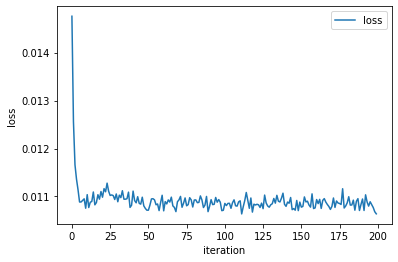

Target optimal controller
[[0.10047046 1.12960651 0.30953934 0.90391817]]
Policy gradient controller
[[0.09985833 1.1249949  0.3087714  0.9032493 ]]
2-norm of controller error:  0.004762249640817979
Spec rad of UNdiscounted linearized system with OPT controller:  1.0360205637729063
post-optimization cost from evaluation:  0.010743276
Spectral radius of UNdiscounted closed-loop:  1.0360736377902642
Cost on undiscounted system (empirical):  5376597.0
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.02698162104934454
	trying discount  0.9464563554727077 , cost:  1590.7999
	trying discount  0.9196845332090615 , cost:  0.028684784

Iteration  3 , initial discount  0.9196845332090615
pre-cost from evaluation:  0.028886242
Target optimal cost:  0.01976577989152489
Running policy gradient...
Final cost  0.019790861755609512


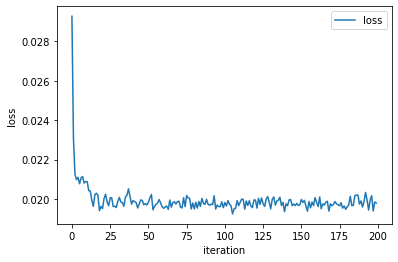

Target optimal controller
[[0.1047231  1.91664053 0.22193753 1.48940264]]
Policy gradient controller
[[0.1041428  1.9118347  0.22111815 1.4888902 ]]
2-norm of controller error:  0.0049362560696169806
Spec rad of UNdiscounted linearized system with OPT controller:  1.022636922674921
post-optimization cost from evaluation:  0.019769343
Spectral radius of UNdiscounted closed-loop:  1.022648277122568
Cost on undiscounted system (empirical):  17158180.0
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.04902656655758619
	trying discount  0.9598422666045308 , cost:  10.34235
	trying discount  0.9397633999067961 , cost:  0.043336097

Iteration  4 , initial discount  0.9397633999067961
pre-cost from evaluation:  0.043288413
Target optimal cost:  0.034057551958979006
Running policy gradient...
Final cost  0.03400640934705734


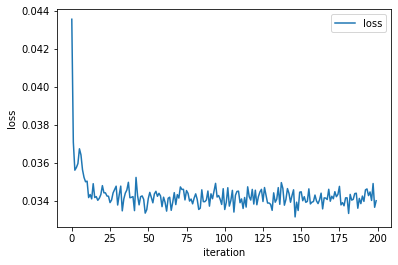

Target optimal controller
[[ 0.06613945  2.82031465 -0.02225431  2.20999893]]
Policy gradient controller
[[ 0.06597675  2.8166156  -0.0224233   2.2111347 ]]
2-norm of controller error:  0.0038766040527708715
Spec rad of UNdiscounted linearized system with OPT controller:  1.0105116335655304
post-optimization cost from evaluation:  0.033615623
Spectral radius of UNdiscounted closed-loop:  1.0105091000131352
Cost on undiscounted system (empirical):  nan
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.08356581442058086
	trying discount  0.9698816999533981 , cost:  0.23690143
	trying discount  0.9548225499300971 , cost:  0.06356161
	trying discount  0.9623521249417476 , cost:  0.1047248
	trying discount  0.9585873374359224 , cost:  0.07964258

Iteration  5 , initial discount  0.9585873374359224
pre-cost from evaluation:  0.07929932
Target optimal cost:  0.061957434584924434
Running policy gradient...
Final cost  0.06267695873975754


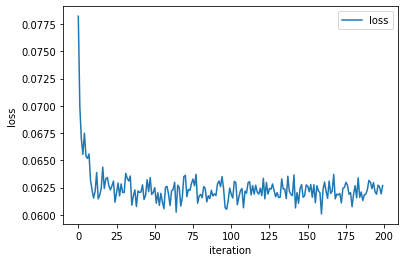

Target optimal controller
[[-0.05074469  4.0731488  -0.55948265  3.2862412 ]]
Policy gradient controller
[[-0.05076878  4.070844   -0.5595295   3.2898304 ]]
2-norm of controller error:  0.004265762156521545
Spec rad of UNdiscounted linearized system with OPT controller:  0.9904552205352438
post-optimization cost from evaluation:  0.062137797
Spectral radius of UNdiscounted closed-loop:  0.99053384039018
Cost on undiscounted system (empirical):  1.3770232
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.15377318486571312
	trying discount  0.9792936687179612 , cost:  0.17105393

Iteration  6 , initial discount  0.9792936687179612
pre-cost from evaluation:  0.16872695
Target optimal cost:  0.12546017243376767
Running policy gradient...
Final cost  0.1276405304670334


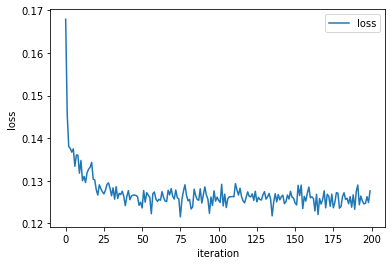

Target optimal controller
[[-0.34174232  6.07872548 -1.71204029  5.12910293]]
Policy gradient controller
[[-0.34116486  6.0746446  -1.7116178   5.130612  ]]
2-norm of controller error:  0.004409397941841977
Spec rad of UNdiscounted linearized system with OPT controller:  0.982476655302741
post-optimization cost from evaluation:  0.123661876
Spectral radius of UNdiscounted closed-loop:  0.9823941089651547
Cost on undiscounted system (empirical):  0.323402
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.32168805599212646
	trying discount  0.9896468343589806 , cost:  0.18491815
	trying discount  0.9948234171794903 , cost:  0.24129425
	trying discount  0.9974117085897451 , cost:  0.2807716

Iteration  7 , initial discount  0.9974117085897451
pre-cost from evaluation:  0.2776406
Target optimal cost:  0.230626375658257
Running policy gradient...
Final cost  0.23324733972549438


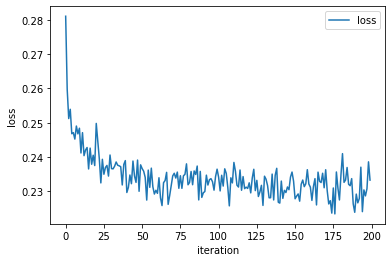

Target optimal controller
[[-0.81070697  8.47929801 -3.36059965  7.44339939]]
Policy gradient controller
[[-0.79833835  8.401209   -3.3069477   7.3338246 ]]
2-norm of controller error:  0.14538243574403298
Spec rad of UNdiscounted linearized system with OPT controller:  0.9745413577439076
post-optimization cost from evaluation:  0.2317045
Spectral radius of UNdiscounted closed-loop:  0.9751155167371627
Cost on undiscounted system (empirical):  0.25372142
J(1) <  2.5 .J(discount) so good enough

Iteration  8 , initial discount  1
pre-cost from evaluation:  0.25667122
Stabilizing controller found on iteration  8
Doing the final policy gradient update
Target optimal cost:  0.251155297638222
Running policy gradient...
Final cost  0.25254830718040466


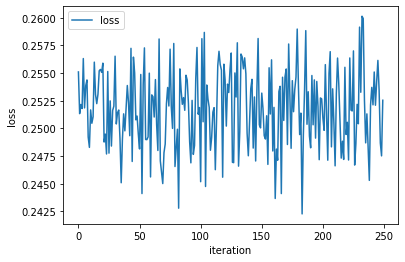

Target optimal controller
[[-0.89970166  8.87862239 -3.65393646  7.835545  ]]
Policy gradient controller
[[-0.89766484  8.876031   -3.6500332   7.8342304 ]]
2-norm of controller error:  0.005275180123935236
Spec rad of UNdiscounted linearized system with OPT controller:  0.9732870857688721
post-optimization cost from evaluation:  0.24867377
Spectral radius of UNdiscounted closed-loop:  0.9733131362681989
Cost on undiscounted system (empirical):  0.25300705
J(1) <  2.5 .J(discount) so good enough

total time:  3879.2876348340005
lwr:  0.1 upr:  0.8
rad:  0.45 cost:  5.4509983
lwr:  0.45 upr:  0.8
rad:  0.625 cost:  11.836925
lwr:  0.625 upr:  0.8
rad:  0.7125 cost:  nan
lwr:  0.625 upr:  0.7125
rad:  0.66875 cost:  14.317637
lwr:  0.66875 upr:  0.7125
rad:  0.690625 cost:  15.970097
lwr:  0.690625 upr:  0.7125
rad:  0.7015625000000001 cost:  16.823278
lwr:  0.7015625000000001 upr:  0.7125
rad:  0.70703125 cost:  nan
lwr:  0.7015625000000001 upr:  0.70703125
rad:  0.704296875 cost:  nan


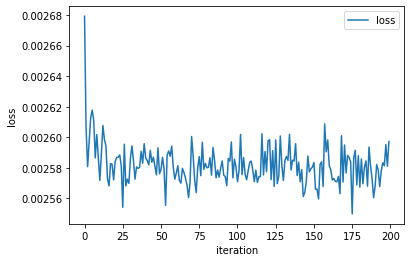

Target optimal controller
[[0.02692094 0.15734008 0.17111459 0.20121149]]
Policy gradient controller
[[0.02691985 0.15627636 0.17102927 0.2010599 ]]
2-norm of controller error:  0.0010778459882477393
Spec rad of UNdiscounted linearized system with OPT controller:  1.0615300805007644
post-optimization cost from evaluation:  0.0025762478
Spectral radius of UNdiscounted closed-loop:  1.0615516954280897
Cost on undiscounted system (empirical):  2591060.8
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.006467571365647018
	trying discount  0.8857735583417765 , cost:  0.07763161
	trying discount  0.8286603375126647 , cost:  0.004198476
	trying discount  0.8572169479272206 , cost:  0.006886775

Iteration  1 , initial discount  0.8572169479272206
pre-cost from evaluation:  0.0069178846
Target optimal cost:  0.005817766070765063
Running policy gradient...
Final cost  0.005803566426038742


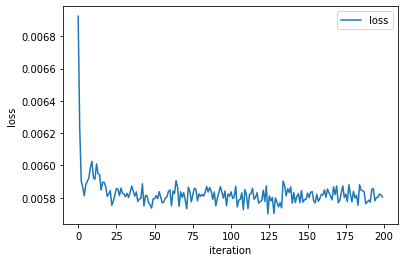

Target optimal controller
[[0.07156047 0.5578161  0.28440931 0.49647784]]
Policy gradient controller
[[0.07151492 0.55445945 0.284345   0.4963003 ]]
2-norm of controller error:  0.003362259162211614
Spec rad of UNdiscounted linearized system with OPT controller:  1.0491516800608056
post-optimization cost from evaluation:  0.0058865743
Spectral radius of UNdiscounted closed-loop:  1.0492069327331113
Cost on undiscounted system (empirical):  4810858.5
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.014511346817016602
	trying discount  0.9286084739636102 , cost:  114.48313
	trying discount  0.8929127109454154 , cost:  0.014725305

Iteration  2 , initial discount  0.8929127109454154
pre-cost from evaluation:  0.01471896
Target optimal cost:  0.010851948563851235
Running policy gradient...
Final cost  0.010874347761273384


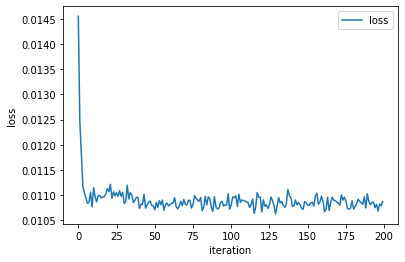

Target optimal controller
[[0.10047046 1.12960651 0.30953934 0.90391817]]
Policy gradient controller
[[0.09982701 1.1250079  0.30869684 0.90326357]]
2-norm of controller error:  0.004764440515494522
Spec rad of UNdiscounted linearized system with OPT controller:  1.0360205637729063
post-optimization cost from evaluation:  0.010750992
Spectral radius of UNdiscounted closed-loop:  1.0360722927913926
Cost on undiscounted system (empirical):  5395443.0
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.027369335293769836
	trying discount  0.9464563554727077 , cost:  1580.2461
	trying discount  0.9196845332090615 , cost:  0.029119592

Iteration  3 , initial discount  0.9196845332090615
pre-cost from evaluation:  0.029152997
Target optimal cost:  0.01976577989152489
Running policy gradient...
Final cost  0.01995743438601494


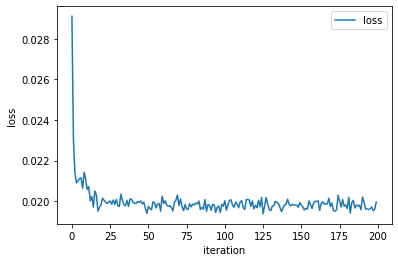

Target optimal controller
[[0.1047231  1.91664053 0.22193753 1.48940264]]
Policy gradient controller
[[0.10415074 1.911828   0.22111331 1.4888784 ]]
2-norm of controller error:  0.004943872318156939
Spec rad of UNdiscounted linearized system with OPT controller:  1.022636922674921
post-optimization cost from evaluation:  0.019731063
Spectral radius of UNdiscounted closed-loop:  1.02264856601736
Cost on undiscounted system (empirical):  17203940.0
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.04969174042344093
	trying discount  0.9598422666045308 , cost:  10.653207
	trying discount  0.9397633999067961 , cost:  0.043263264

Iteration  4 , initial discount  0.9397633999067961
pre-cost from evaluation:  0.044570558
Target optimal cost:  0.034057551958979006
Running policy gradient...
Final cost  0.03400127589702606


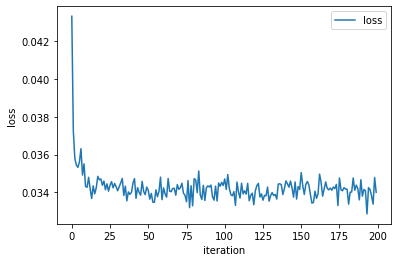

Target optimal controller
[[ 0.06613945  2.82031465 -0.02225431  2.20999893]]
Policy gradient controller
[[ 0.06597181  2.8166187  -0.02243194  2.211154  ]]
2-norm of controller error:  0.0038799495136474355
Spec rad of UNdiscounted linearized system with OPT controller:  1.0105116335655304
post-optimization cost from evaluation:  0.033783652
Spectral radius of UNdiscounted closed-loop:  1.010508629509693
Cost on undiscounted system (empirical):  nan
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.0847114622592926
	trying discount  0.9698816999533981 , cost:  0.22971879
	trying discount  0.9548225499300971 , cost:  0.06273516
	trying discount  0.9623521249417476 , cost:  0.10636784
	trying discount  0.9585873374359224 , cost:  0.07890855

Iteration  5 , initial discount  0.9585873374359224
pre-cost from evaluation:  0.07811478
Target optimal cost:  0.061957434584924434
Running policy gradient...
Final cost  0.06226412206888199


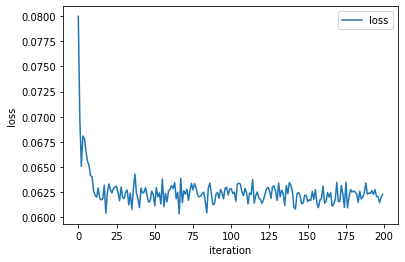

Target optimal controller
[[-0.05074469  4.0731488  -0.55948265  3.2862412 ]]
Policy gradient controller
[[-0.05076139  4.0707827  -0.55955684  3.2898335 ]]
2-norm of controller error:  0.00430224394330451
Spec rad of UNdiscounted linearized system with OPT controller:  0.9904552205352438
post-optimization cost from evaluation:  0.061688904
Spectral radius of UNdiscounted closed-loop:  0.9905455444549156
Cost on undiscounted system (empirical):  1.411572
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.15641048550605774
	trying discount  0.9792936687179612 , cost:  0.16870576

Iteration  6 , initial discount  0.9792936687179612
pre-cost from evaluation:  0.1717952
Target optimal cost:  0.12546017243376767
Running policy gradient...
Final cost  0.12261246144771576


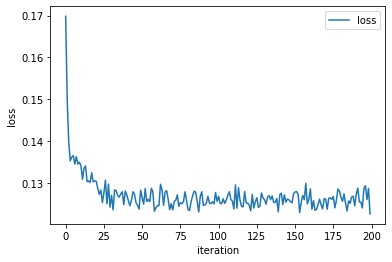

Target optimal controller
[[-0.34174232  6.07872548 -1.71204029  5.12910293]]
Policy gradient controller
[[-0.34112054  6.074183   -1.7113426   5.1298604 ]]
2-norm of controller error:  0.004699087528095464
Spec rad of UNdiscounted linearized system with OPT controller:  0.982476655302741
post-optimization cost from evaluation:  0.12889999
Spectral radius of UNdiscounted closed-loop:  0.9823974174081229
Cost on undiscounted system (empirical):  0.3246333
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.32167185097932816
	trying discount  0.9896468343589806 , cost:  0.18560402
	trying discount  0.9948234171794903 , cost:  0.2433707
	trying discount  0.9974117085897451 , cost:  0.2802567

Iteration  7 , initial discount  0.9974117085897451
pre-cost from evaluation:  0.2777196
Target optimal cost:  0.230626375658257
Running policy gradient...
Final cost  0.23485949635505676


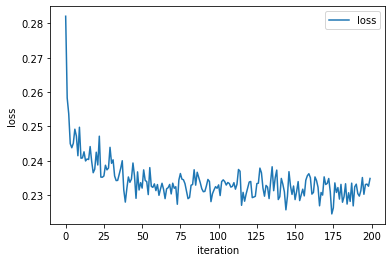

Target optimal controller
[[-0.81070697  8.47929801 -3.36059965  7.44339939]]
Policy gradient controller
[[-0.798631   8.403065  -3.3083475  7.3365917]]
2-norm of controller error:  0.1417586355811556
Spec rad of UNdiscounted linearized system with OPT controller:  0.9745413577439076
post-optimization cost from evaluation:  0.23219435
Spectral radius of UNdiscounted closed-loop:  0.9750967704633745
Cost on undiscounted system (empirical):  0.25642222
J(1) <  2.5 .J(discount) so good enough

Iteration  8 , initial discount  1
pre-cost from evaluation:  0.2508123
Stabilizing controller found on iteration  8
Doing the final policy gradient update
Target optimal cost:  0.251155297638222
Running policy gradient...
Final cost  0.2530331611633301


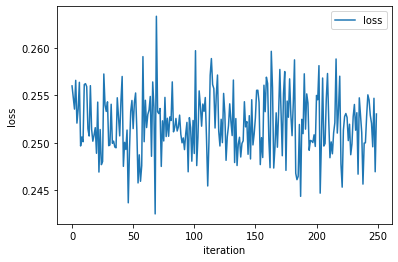

Target optimal controller
[[-0.89970166  8.87862239 -3.65393646  7.835545  ]]
Policy gradient controller
[[-0.8976263  8.876057  -3.6499228  7.8343773]]
2-norm of controller error:  0.005325661752191366
Spec rad of UNdiscounted linearized system with OPT controller:  0.9732870857688721
post-optimization cost from evaluation:  0.2510745
Spectral radius of UNdiscounted closed-loop:  0.9733148685086949
Cost on undiscounted system (empirical):  0.24529003
J(1) <  2.5 .J(discount) so good enough

total time:  3914.5196666070005
lwr:  0.1 upr:  0.8
rad:  0.45 cost:  5.4940357
lwr:  0.45 upr:  0.8
rad:  0.625 cost:  11.84314
lwr:  0.625 upr:  0.8
rad:  0.7125 cost:  nan
lwr:  0.625 upr:  0.7125
rad:  0.66875 cost:  14.303395
lwr:  0.66875 upr:  0.7125
rad:  0.690625 cost:  15.504866
lwr:  0.690625 upr:  0.7125
rad:  0.7015625000000001 cost:  16.599981
lwr:  0.7015625000000001 upr:  0.7125
rad:  0.70703125 cost:  nan
lwr:  0.7015625000000001 upr:  0.70703125
rad:  0.704296875 cost:  16.989534


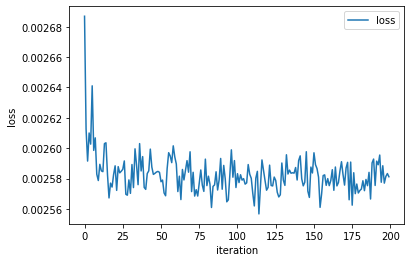

Target optimal controller
[[0.02692094 0.15734008 0.17111459 0.20121149]]
Policy gradient controller
[[0.02691198 0.15628313 0.17100689 0.20105071]]
2-norm of controller error:  0.0010745566574520602
Spec rad of UNdiscounted linearized system with OPT controller:  1.0615300805007644
post-optimization cost from evaluation:  0.0025927466
Spectral radius of UNdiscounted closed-loop:  1.0615519740519606
Cost on undiscounted system (empirical):  2590345.2
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.006436426774598658
	trying discount  0.8857735583417765 , cost:  0.07595935
	trying discount  0.8286603375126647 , cost:  0.004181131
	trying discount  0.8572169479272206 , cost:  0.0068129716

Iteration  1 , initial discount  0.8572169479272206
pre-cost from evaluation:  0.0068463758
Target optimal cost:  0.005817766070765063
Running policy gradient...
Final cost  0.00589278619736433


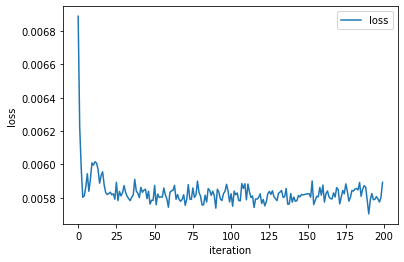

Target optimal controller
[[0.07156047 0.5578161  0.28440931 0.49647784]]
Policy gradient controller
[[0.0715318  0.5545088  0.28435516 0.496298  ]]
2-norm of controller error:  0.0033127447446616148
Spec rad of UNdiscounted linearized system with OPT controller:  1.0491516800608056
post-optimization cost from evaluation:  0.0058110915
Spectral radius of UNdiscounted closed-loop:  1.0492062093228065
Cost on undiscounted system (empirical):  4807590.5
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.014558866387233138
	trying discount  0.9286084739636102 , cost:  113.990395
	trying discount  0.8929127109454154 , cost:  0.014602189

Iteration  2 , initial discount  0.8929127109454154
pre-cost from evaluation:  0.014598797
Target optimal cost:  0.010851948563851235
Running policy gradient...
Final cost  0.010763941332697868


Target optimal controller
[[0.10047046 1.12960651 0.30953934 0.90391817]]
Policy gradient controller
[[0.09991641 1.1250137  0.3087769  0.90325236]]
2-norm of controller error:  0.004735554528459141
Spec rad of UNdiscounted linearized system with OPT controller:  1.0360205637729063
post-optimization cost from evaluation:  0.010894348
Spectral radius of UNdiscounted closed-loop:  1.0360741154480022
Cost on undiscounted system (empirical):  5383675.0
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.026753032580018044
	trying discount  0.9464563554727077 , cost:  1584.3954
	trying discount  0.9196845332090615 , cost:  0.029484307

Iteration  3 , initial discount  0.9196845332090615
pre-cost from evaluation:  0.028701572
Target optimal cost:  0.01976577989152489
Running policy gradient...
Final cost  0.01970258727669716


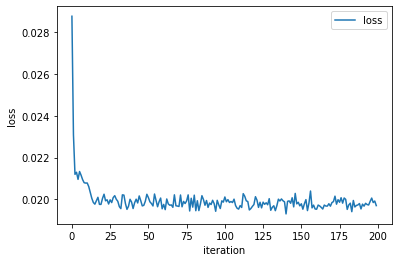

Target optimal controller
[[0.1047231  1.91664053 0.22193753 1.48940264]]
Policy gradient controller
[[0.10415746 1.9118663  0.22112603 1.488862  ]]
2-norm of controller error:  0.004905502460406315
Spec rad of UNdiscounted linearized system with OPT controller:  1.022636922674921
post-optimization cost from evaluation:  0.01966649
Spectral radius of UNdiscounted closed-loop:  1.0226487133964852
Cost on undiscounted system (empirical):  17244912.0
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.049358680844306946
	trying discount  0.9598422666045308 , cost:  10.531795
	trying discount  0.9397633999067961 , cost:  0.04316706

Iteration  4 , initial discount  0.9397633999067961
pre-cost from evaluation:  0.043201774
Target optimal cost:  0.034057551958979006
Running policy gradient...
Final cost  0.033934637904167175


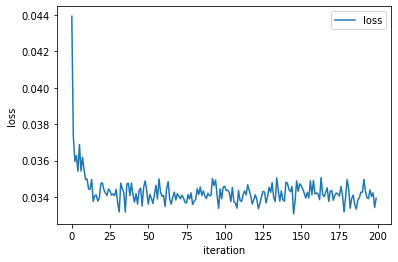

Target optimal controller
[[ 0.06613945  2.82031465 -0.02225431  2.20999893]]
Policy gradient controller
[[ 0.06596801  2.816625   -0.02241503  2.2111306 ]]
2-norm of controller error:  0.003866341878949482
Spec rad of UNdiscounted linearized system with OPT controller:  1.0105116335655304
post-optimization cost from evaluation:  0.034143813
Spectral radius of UNdiscounted closed-loop:  1.0105086090373376
Cost on undiscounted system (empirical):  nan
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.0851621013134718
	trying discount  0.9698816999533981 , cost:  0.23865883
	trying discount  0.9548225499300971 , cost:  0.06247367
	trying discount  0.9623521249417476 , cost:  0.10528264
	trying discount  0.9585873374359224 , cost:  0.07906933

Iteration  5 , initial discount  0.9585873374359224
pre-cost from evaluation:  0.078317836
Target optimal cost:  0.061957434584924434
Running policy gradient...
Final cost  0.06170729920268059


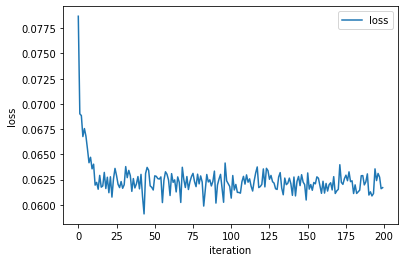

Target optimal controller
[[-0.05074469  4.0731488  -0.55948265  3.2862412 ]]
Policy gradient controller
[[-0.05076089  4.07079    -0.55954766  3.2898088 ]]
2-norm of controller error:  0.004277461719862704
Spec rad of UNdiscounted linearized system with OPT controller:  0.9904552205352438
post-optimization cost from evaluation:  0.062433653
Spectral radius of UNdiscounted closed-loop:  0.9905442290877399
Cost on undiscounted system (empirical):  1.4129834
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.15512418933212757
	trying discount  0.9792936687179612 , cost:  0.17142226

Iteration  6 , initial discount  0.9792936687179612
pre-cost from evaluation:  0.1734843
Target optimal cost:  0.12546017243376767
Running policy gradient...
Final cost  0.1263173520565033


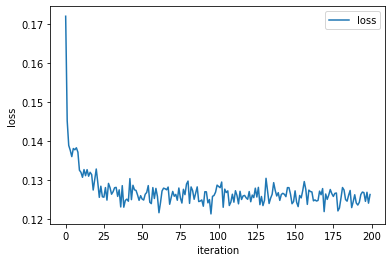

Target optimal controller
[[-0.34174232  6.07872548 -1.71204029  5.12910293]]
Policy gradient controller
[[-0.34114382  6.074349   -1.7114339   5.130092  ]]
2-norm of controller error:  0.004567132522419565
Spec rad of UNdiscounted linearized system with OPT controller:  0.982476655302741
post-optimization cost from evaluation:  0.12447126
Spectral radius of UNdiscounted closed-loop:  0.9823969813732569
Cost on undiscounted system (empirical):  0.3202413
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.3158963471651077
	trying discount  0.9896468343589806 , cost:  0.18979621
	trying discount  0.9948234171794903 , cost:  0.24237119
	trying discount  0.9974117085897451 , cost:  0.2830647

Iteration  7 , initial discount  0.9974117085897451
pre-cost from evaluation:  0.27964228
Target optimal cost:  0.230626375658257
Running policy gradient...
Final cost  0.2287994623184204


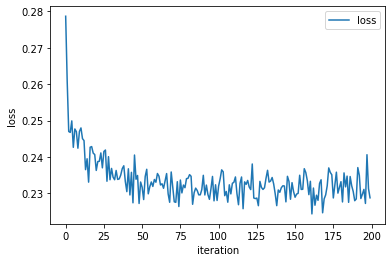

Target optimal controller
[[-0.81070697  8.47929801 -3.36059965  7.44339939]]
Policy gradient controller
[[-0.7986974  8.403473  -3.3084598  7.3368545]]
2-norm of controller error:  0.14129425685251282
Spec rad of UNdiscounted linearized system with OPT controller:  0.9745413577439076
post-optimization cost from evaluation:  0.22771245
Spectral radius of UNdiscounted closed-loop:  0.9751020416617333
Cost on undiscounted system (empirical):  0.25500506
J(1) <  2.5 .J(discount) so good enough

Iteration  8 , initial discount  1
pre-cost from evaluation:  0.25003892
Stabilizing controller found on iteration  8
Doing the final policy gradient update
Target optimal cost:  0.251155297638222
Running policy gradient...
Final cost  0.24683524668216705


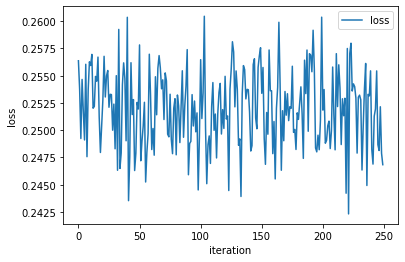

Target optimal controller
[[-0.89970166  8.87862239 -3.65393646  7.835545  ]]
Policy gradient controller
[[-0.89772516  8.875987   -3.649943    7.8344965 ]]
2-norm of controller error:  0.005281821364120403
Spec rad of UNdiscounted linearized system with OPT controller:  0.9732870857688721
post-optimization cost from evaluation:  0.2494308
Spectral radius of UNdiscounted closed-loop:  0.9733130535403466
Cost on undiscounted system (empirical):  0.25504625
J(1) <  2.5 .J(discount) so good enough

total time:  3852.771087621999
lwr:  0.1 upr:  0.8
rad:  0.45 cost:  5.508846
lwr:  0.45 upr:  0.8
rad:  0.625 cost:  11.64735
lwr:  0.625 upr:  0.8
rad:  0.7125 cost:  nan
lwr:  0.625 upr:  0.7125
rad:  0.66875 cost:  14.159812
lwr:  0.66875 upr:  0.7125
rad:  0.690625 cost:  15.651946
lwr:  0.690625 upr:  0.7125
rad:  0.7015625000000001 cost:  16.65646
lwr:  0.7015625000000001 upr:  0.7125
rad:  0.70703125 cost:  nan
lwr:  0.7015625000000001 upr:  0.70703125
rad:  0.704296875 cost:  nan
lwr: 

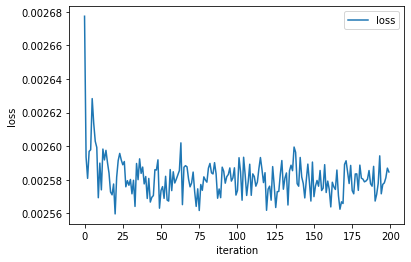

Target optimal controller
[[0.02692094 0.15734008 0.17111459 0.20121149]]
Policy gradient controller
[[0.02691585 0.15628982 0.17104039 0.20106831]]
2-norm of controller error:  0.0010625801195731826
Spec rad of UNdiscounted linearized system with OPT controller:  1.0615300805007644
post-optimization cost from evaluation:  0.0025863957
Spectral radius of UNdiscounted closed-loop:  1.0615512398618907
Cost on undiscounted system (empirical):  2584896.8
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.006452553207054734
	trying discount  0.8857735583417765 , cost:  0.07733547
	trying discount  0.8286603375126647 , cost:  0.0041774698
	trying discount  0.8572169479272206 , cost:  0.0069554015

Iteration  1 , initial discount  0.8572169479272206
pre-cost from evaluation:  0.0069018085
Target optimal cost:  0.005817766070765063
Running policy gradient...
Final cost  0.005831144750118256


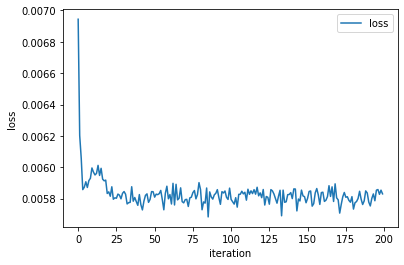

Target optimal controller
[[0.07156047 0.5578161  0.28440931 0.49647784]]
Policy gradient controller
[[0.07155881 0.55448097 0.28430802 0.49625173]]
2-norm of controller error:  0.0033443173789888857
Spec rad of UNdiscounted linearized system with OPT controller:  1.0491516800608056
post-optimization cost from evaluation:  0.0058023483
Spectral radius of UNdiscounted closed-loop:  1.0492073482879913
Cost on undiscounted system (empirical):  4806768.0
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.014613419771194458
	trying discount  0.9286084739636102 , cost:  114.961624
	trying discount  0.8929127109454154 , cost:  0.014688824

Iteration  2 , initial discount  0.8929127109454154
pre-cost from evaluation:  0.014724928
Target optimal cost:  0.010851948563851235
Running policy gradient...
Final cost  0.010850727558135986


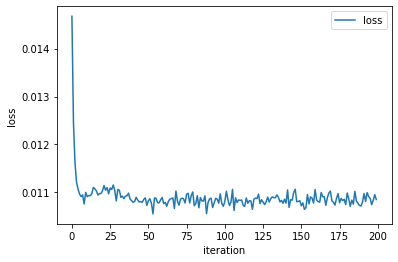

Target optimal controller
[[0.10047046 1.12960651 0.30953934 0.90391817]]
Policy gradient controller
[[0.09989263 1.1249835  0.30878195 0.90326244]]
2-norm of controller error:  0.004765429891285792
Spec rad of UNdiscounted linearized system with OPT controller:  1.0360205637729063
post-optimization cost from evaluation:  0.010572401
Spectral radius of UNdiscounted closed-loop:  1.036074173122355
Cost on undiscounted system (empirical):  5365146.5
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.027455405797809362
	trying discount  0.9464563554727077 , cost:  1583.4705
	trying discount  0.9196845332090615 , cost:  0.028826043

Iteration  3 , initial discount  0.9196845332090615
pre-cost from evaluation:  0.0286937
Target optimal cost:  0.01976577989152489
Running policy gradient...
Final cost  0.01969420537352562


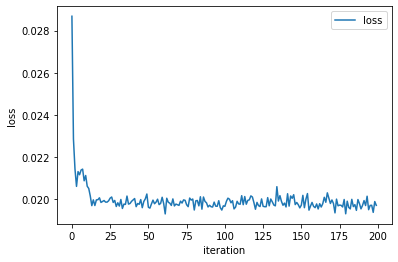

Target optimal controller
[[0.1047231  1.91664053 0.22193753 1.48940264]]
Policy gradient controller
[[0.10416348 1.9118671  0.22113338 1.4888825 ]]
2-norm of controller error:  0.004900570941300182
Spec rad of UNdiscounted linearized system with OPT controller:  1.022636922674921
post-optimization cost from evaluation:  0.019749807
Spectral radius of UNdiscounted closed-loop:  1.022648933170224
Cost on undiscounted system (empirical):  17159940.0
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.04875143524259329
	trying discount  0.9598422666045308 , cost:  10.741981
	trying discount  0.9397633999067961 , cost:  0.043017033

Iteration  4 , initial discount  0.9397633999067961
pre-cost from evaluation:  0.042209912
Target optimal cost:  0.034057551958979006
Running policy gradient...
Final cost  0.033845603466033936


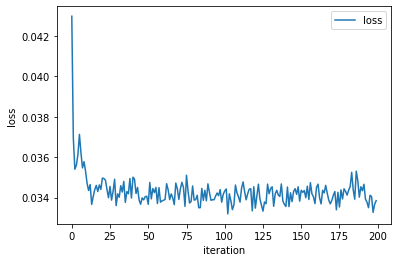

Target optimal controller
[[ 0.06613945  2.82031465 -0.02225431  2.20999893]]
Policy gradient controller
[[ 0.06597016  2.8166122  -0.02243664  2.2111864 ]]
2-norm of controller error:  0.0038961312768882837
Spec rad of UNdiscounted linearized system with OPT controller:  1.0105116335655304
post-optimization cost from evaluation:  0.034207255
Spectral radius of UNdiscounted closed-loop:  1.0105084535653097
Cost on undiscounted system (empirical):  nan
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.08560479618608952
	trying discount  0.9698816999533981 , cost:  0.22938901
	trying discount  0.9548225499300971 , cost:  0.062063567
	trying discount  0.9623521249417476 , cost:  0.102874726
	trying discount  0.9585873374359224 , cost:  0.079580024

Iteration  5 , initial discount  0.9585873374359224
pre-cost from evaluation:  0.07912269
Target optimal cost:  0.061957434584924434
Running policy gradient...
Final cost  0.0608498714864254


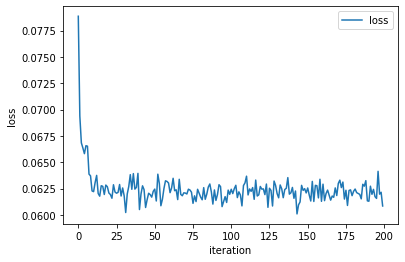

Target optimal controller
[[-0.05074469  4.0731488  -0.55948265  3.2862412 ]]
Policy gradient controller
[[-0.05076619  4.070834   -0.5595237   3.2898028 ]]
2-norm of controller error:  0.004247892251686305
Spec rad of UNdiscounted linearized system with OPT controller:  0.9904552205352438
post-optimization cost from evaluation:  0.062434457
Spectral radius of UNdiscounted closed-loop:  0.9905351598175904
Cost on undiscounted system (empirical):  1.425977
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.15701759606599808
	trying discount  0.9792936687179612 , cost:  0.17251132

Iteration  6 , initial discount  0.9792936687179612
pre-cost from evaluation:  0.17210329
Target optimal cost:  0.12546017243376767
Running policy gradient...
Final cost  0.12629924714565277


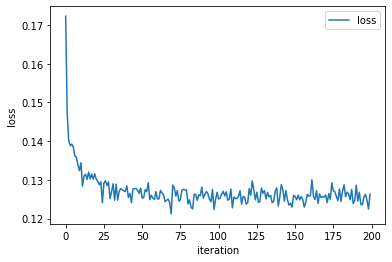

Target optimal controller
[[-0.34174232  6.07872548 -1.71204029  5.12910293]]
Policy gradient controller
[[-0.3411234  6.074167  -1.7113173  5.1297355]]
2-norm of controller error:  0.004699752575780465
Spec rad of UNdiscounted linearized system with OPT controller:  0.982476655302741
post-optimization cost from evaluation:  0.1240405
Spectral radius of UNdiscounted closed-loop:  0.982398644827235
Cost on undiscounted system (empirical):  0.32741597
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.31327024102211
	trying discount  0.9896468343589806 , cost:  0.19113761
	trying discount  0.9948234171794903 , cost:  0.23988032
	trying discount  0.9974117085897451 , cost:  0.2801142

Iteration  7 , initial discount  0.9974117085897451
pre-cost from evaluation:  0.27976987
Target optimal cost:  0.230626375658257
Running policy gradient...
Final cost  0.23154261708259583


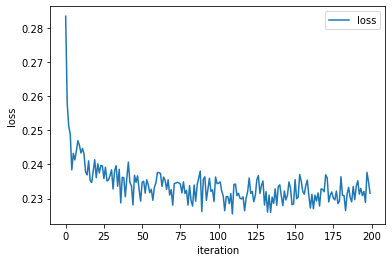

Target optimal controller
[[-0.81070697  8.47929801 -3.36059965  7.44339939]]
Policy gradient controller
[[-0.79848856  8.401873   -3.3073497   7.3347044 ]]
2-norm of controller error:  0.14420172649753263
Spec rad of UNdiscounted linearized system with OPT controller:  0.9745413577439076
post-optimization cost from evaluation:  0.22963691
Spectral radius of UNdiscounted closed-loop:  0.9751138388899505
Cost on undiscounted system (empirical):  0.2526614
J(1) <  2.5 .J(discount) so good enough

Iteration  8 , initial discount  1
pre-cost from evaluation:  0.25157708
Stabilizing controller found on iteration  8
Doing the final policy gradient update
Target optimal cost:  0.251155297638222
Running policy gradient...
Final cost  0.2531368136405945


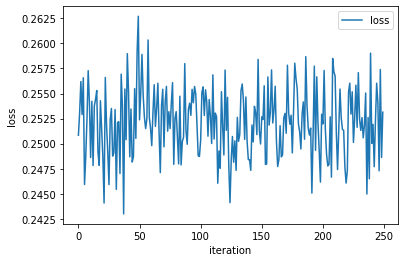

Target optimal controller
[[-0.89970166  8.87862239 -3.65393646  7.835545  ]]
Policy gradient controller
[[-0.89770687  8.876057   -3.6499116   7.834361  ]]
2-norm of controller error:  0.005306870876533171
Spec rad of UNdiscounted linearized system with OPT controller:  0.9732870857688721
post-optimization cost from evaluation:  0.25290945
Spectral radius of UNdiscounted closed-loop:  0.9733172610544601
Cost on undiscounted system (empirical):  0.24684677
J(1) <  2.5 .J(discount) so good enough

total time:  3856.7465201390005
lwr:  0.1 upr:  0.8
rad:  0.45 cost:  5.5185623
lwr:  0.45 upr:  0.8
rad:  0.625 cost:  11.82279
lwr:  0.625 upr:  0.8
rad:  0.7125 cost:  nan
lwr:  0.625 upr:  0.7125
rad:  0.66875 cost:  14.1112385
lwr:  0.66875 upr:  0.7125
rad:  0.690625 cost:  15.790848
lwr:  0.690625 upr:  0.7125
rad:  0.7015625000000001 cost:  16.682722
lwr:  0.7015625000000001 upr:  0.7125
rad:  0.70703125 cost:  nan
lwr:  0.7015625000000001 upr:  0.70703125
rad:  0.704296875 cost:  nan


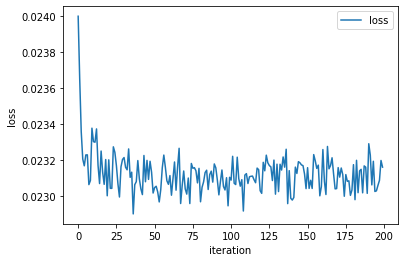

Target optimal controller
[[0.02692094 0.15734008 0.17111459 0.20121149]]
Policy gradient controller
[[0.02686533 0.148426   0.17035718 0.19995831]]
2-norm of controller error:  0.009033715794672449
Spec rad of UNdiscounted linearized system with OPT controller:  1.0615300805007644
post-optimization cost from evaluation:  0.023164388
Spectral radius of UNdiscounted closed-loop:  1.0617113922858155
Cost on undiscounted system (empirical):  2576435.5
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.057544768787920475
	trying discount  0.8857735583417765 , cost:  0.56860906
	trying discount  0.8286603375126647 , cost:  0.03653218
	trying discount  0.8572169479272206 , cost:  0.060796153

Iteration  1 , initial discount  0.8572169479272206
pre-cost from evaluation:  0.06055828
Target optimal cost:  0.05235989463688556
Running policy gradient...
Final cost  0.052107762545347214


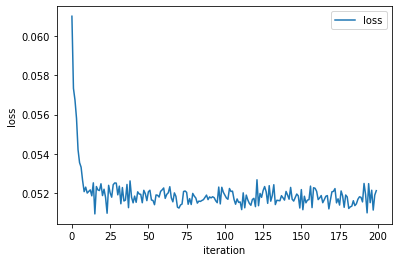

Target optimal controller
[[0.07156047 0.5578161  0.28440931 0.49647784]]
Policy gradient controller
[[0.07126125 0.529239   0.28371307 0.494529  ]]
2-norm of controller error:  0.028653494419296727
Spec rad of UNdiscounted linearized system with OPT controller:  1.0491516800608056
post-optimization cost from evaluation:  0.052554052
Spectral radius of UNdiscounted closed-loop:  1.0496287151291812
Cost on undiscounted system (empirical):  5244613.5
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.12995336204767227
	trying discount  0.9286084739636102 , cost:  152.52345
	trying discount  0.8929127109454154 , cost:  0.1316725

Iteration  2 , initial discount  0.8929127109454154
pre-cost from evaluation:  0.13207865
Target optimal cost:  0.0976675370746611
Running policy gradient...
Final cost  0.09790902584791183


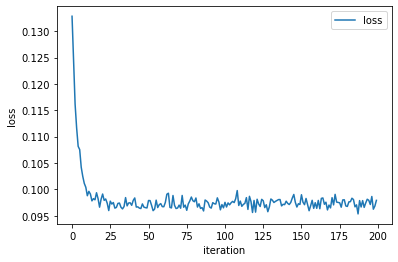

Target optimal controller
[[0.10047046 1.12960651 0.30953934 0.90391817]]
Policy gradient controller
[[0.09541563 1.0879039  0.30359837 0.900556  ]]
2-norm of controller error:  0.042558924183962246
Spec rad of UNdiscounted linearized system with OPT controller:  1.0360205637729063
post-optimization cost from evaluation:  0.09790489
Spectral radius of UNdiscounted closed-loop:  1.0364957815129947
Cost on undiscounted system (empirical):  6542340.0
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.2408367395401001
	trying discount  0.9464563554727077 , cost:  2130.4143
	trying discount  0.9196845332090615 , cost:  0.27258825

Iteration  3 , initial discount  0.9196845332090615
pre-cost from evaluation:  0.26508543
Target optimal cost:  0.17789201902372398
Running policy gradient...
Final cost  0.17783766984939575


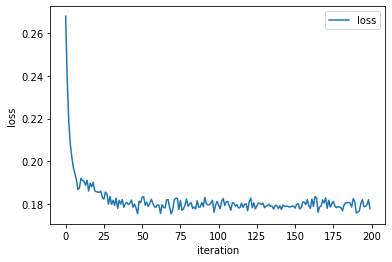

Target optimal controller
[[0.1047231  1.91664053 0.22193753 1.48940264]]
Policy gradient controller
[[0.10040768 1.8696611  0.21037047 1.4807984 ]]
2-norm of controller error:  0.04933073289506817
Spec rad of UNdiscounted linearized system with OPT controller:  1.022636922674921
post-optimization cost from evaluation:  0.17791297
Spectral radius of UNdiscounted closed-loop:  1.0227567828841329
Cost on undiscounted system (empirical):  24984114.0
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.44670090079307556
	trying discount  0.9598422666045308 , cost:  764.23596
	trying discount  0.9397633999067961 , cost:  0.4008538

Iteration  4 , initial discount  0.9397633999067961
pre-cost from evaluation:  0.39409167
Target optimal cost:  0.30651796763081096
Running policy gradient...
Final cost  0.31480512022972107


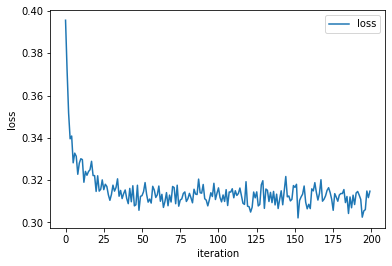

Target optimal controller
[[ 0.06613945  2.82031465 -0.02225431  2.20999893]]
Policy gradient controller
[[ 0.06536074  2.7850764  -0.02521571  2.218236  ]]
2-norm of controller error:  0.03631750162303941
Spec rad of UNdiscounted linearized system with OPT controller:  1.0105116335655304
post-optimization cost from evaluation:  0.31030083
Spectral radius of UNdiscounted closed-loop:  1.010521585143913
Cost on undiscounted system (empirical):  nan
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.7868996262550354
	trying discount  0.9698816999533981 , cost:  2.1982622
	trying discount  0.9548225499300971 , cost:  0.5924219
	trying discount  0.9623521249417476 , cost:  0.9671275
	trying discount  0.9585873374359224 , cost:  0.7034302

Iteration  5 , initial discount  0.9585873374359224
pre-cost from evaluation:  0.73060447
Target optimal cost:  0.5576169112643198
Running policy gradient...
Final cost  0.5709536671638489


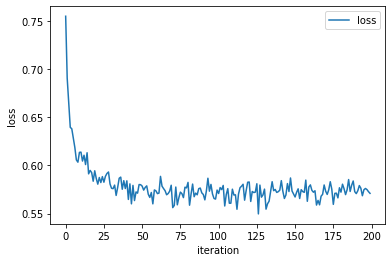

Target optimal controller
[[-0.05074469  4.0731488  -0.55948265  3.2862412 ]]
Policy gradient controller
[[-0.0496277  4.0441275 -0.5615393  3.314584 ]]
2-norm of controller error:  0.0406328715390572
Spec rad of UNdiscounted linearized system with OPT controller:  0.9904552205352438
post-optimization cost from evaluation:  0.57330525
Spectral radius of UNdiscounted closed-loop:  0.9919060422942085
Cost on undiscounted system (empirical):  13.342067
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  1.4377433061599731
	trying discount  0.9792936687179612 , cost:  1.5857918

Iteration  6 , initial discount  0.9792936687179612
pre-cost from evaluation:  1.5763608
Target optimal cost:  1.1291415519039087
Running policy gradient...
Final cost  1.1575417518615723


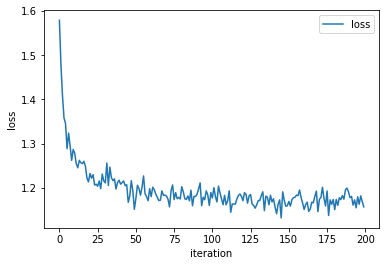

Target optimal controller
[[-0.34174232  6.07872548 -1.71204029  5.12910293]]
Policy gradient controller
[[-0.31396022  5.803859   -1.5636146   4.724085  ]]
2-norm of controller error:  0.512243222855118
Spec rad of UNdiscounted linearized system with OPT controller:  0.982476655302741
post-optimization cost from evaluation:  1.1688465
Spectral radius of UNdiscounted closed-loop:  0.9836357518812052
Cost on undiscounted system (empirical):  3.0854578
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  2.9547688364982605
	trying discount  0.9896468343589806 , cost:  1.7408987
	trying discount  0.9948234171794903 , cost:  2.2579823
	trying discount  0.9974117085897451 , cost:  2.6254148

Iteration  7 , initial discount  0.9974117085897451
pre-cost from evaluation:  2.6218398
Target optimal cost:  2.0756373809243125
Running policy gradient...
Final cost  2.1918230056762695


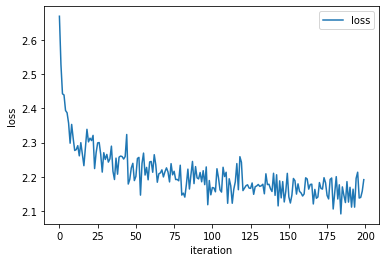

Target optimal controller
[[-0.81070697  8.47929801 -3.36059965  7.44339939]]
Policy gradient controller
[[-0.683006   7.6709404 -2.794029   6.2850037]]
2-norm of controller error:  1.5272958222180326
Spec rad of UNdiscounted linearized system with OPT controller:  0.9745413577439076
post-optimization cost from evaluation:  2.196626
Spectral radius of UNdiscounted closed-loop:  0.979636937221009
Cost on undiscounted system (empirical):  2.3795958
J(1) <  2.5 .J(discount) so good enough

Iteration  8 , initial discount  1
pre-cost from evaluation:  2.3722572
Stabilizing controller found on iteration  8
Doing the final policy gradient update
Target optimal cost:  2.2603976787439977
Running policy gradient...
Final cost  2.3348143100738525


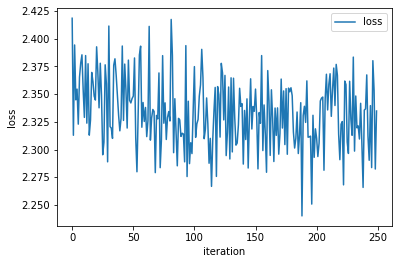

Target optimal controller
[[-0.89970166  8.87862239 -3.65393646  7.835545  ]]
Policy gradient controller
[[-0.88146955  8.868837   -3.6204858   7.836733  ]]
2-norm of controller error:  0.039351176825298075
Spec rad of UNdiscounted linearized system with OPT controller:  0.9732870857688721
post-optimization cost from evaluation:  2.3937626
Spectral radius of UNdiscounted closed-loop:  0.9736871606416391
Cost on undiscounted system (empirical):  2.3388133
J(1) <  2.5 .J(discount) so good enough

total time:  3890.886016421002
lwr:  0.3 upr:  0.8
rad:  0.55 cost:  8.570471
lwr:  0.55 upr:  0.8
rad:  0.675 cost:  14.393166
lwr:  0.675 upr:  0.8
rad:  0.7375 cost:  nan
lwr:  0.675 upr:  0.7375
rad:  0.70625 cost:  16.661005
lwr:  0.70625 upr:  0.7375
rad:  0.721875 cost:  nan
lwr:  0.70625 upr:  0.721875
rad:  0.7140625 cost:  nan
lwr:  0.70625 upr:  0.7140625
rad:  0.71015625 cost:  17.15935
lwr:  0.71015625 upr:  0.7140625
rad:  0.712109375 cost:  17.482656
lwr:  0.712109375 upr:  0.7140

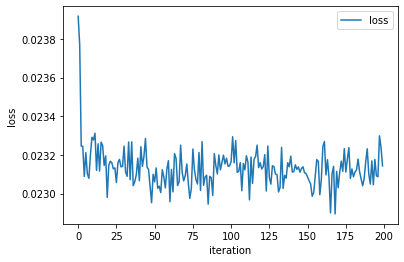

Target optimal controller
[[0.02692094 0.15734008 0.17111459 0.20121149]]
Policy gradient controller
[[0.02689883 0.14840966 0.17035426 0.19980608]]
2-norm of controller error:  0.00907226530535695
Spec rad of UNdiscounted linearized system with OPT controller:  1.0615300805007644
post-optimization cost from evaluation:  0.02323207
Spectral radius of UNdiscounted closed-loop:  1.0617146474069974
Cost on undiscounted system (empirical):  2566436.0
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.05770536605268717
	trying discount  0.8857735583417765 , cost:  0.5676351
	trying discount  0.8286603375126647 , cost:  0.03758649
	trying discount  0.8572169479272206 , cost:  0.060374185

Iteration  1 , initial discount  0.8572169479272206
pre-cost from evaluation:  0.0614239
Target optimal cost:  0.05235989463688556
Running policy gradient...
Final cost  0.05218198150396347


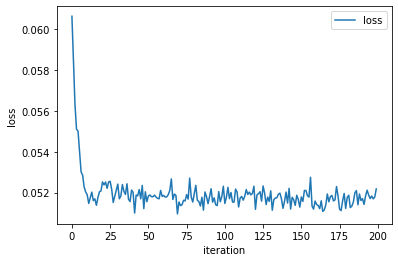

Target optimal controller
[[0.07156047 0.5578161  0.28440931 0.49647784]]
Policy gradient controller
[[0.07124074 0.529487   0.28354594 0.49458733]]
2-norm of controller error:  0.028407016610354753
Spec rad of UNdiscounted linearized system with OPT controller:  1.0491516800608056
post-optimization cost from evaluation:  0.051332407
Spectral radius of UNdiscounted closed-loop:  1.0496238867065222
Cost on undiscounted system (empirical):  5258924.0
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.13067184016108513
	trying discount  0.9286084739636102 , cost:  151.89977
	trying discount  0.8929127109454154 , cost:  0.13038236

Iteration  2 , initial discount  0.8929127109454154
pre-cost from evaluation:  0.12954058
Target optimal cost:  0.0976675370746611
Running policy gradient...
Final cost  0.09620089828968048


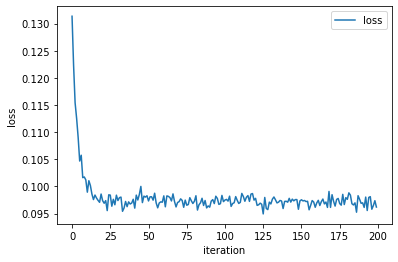

Target optimal controller
[[0.10047046 1.12960651 0.30953934 0.90391817]]
Policy gradient controller
[[0.09576523 1.0880702  0.3034896  0.9004672 ]]
2-norm of controller error:  0.042378259605405866
Spec rad of UNdiscounted linearized system with OPT controller:  1.0360205637729063
post-optimization cost from evaluation:  0.09787867
Spectral radius of UNdiscounted closed-loop:  1.0364975996670094
Cost on undiscounted system (empirical):  6520445.0
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.24503223598003387
	trying discount  0.9464563554727077 , cost:  2126.8096
	trying discount  0.9196845332090615 , cost:  0.26704437

Iteration  3 , initial discount  0.9196845332090615
pre-cost from evaluation:  0.26780027
Target optimal cost:  0.17789201902372398
Running policy gradient...
Final cost  0.17866851389408112


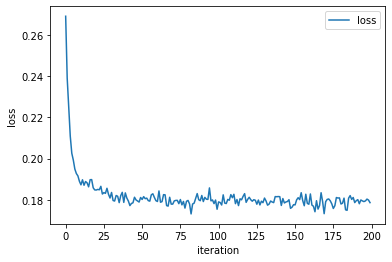

Target optimal controller
[[0.1047231  1.91664053 0.22193753 1.48940264]]
Policy gradient controller
[[0.10043084 1.8695618  0.21016578 1.480663  ]]
2-norm of controller error:  0.04949533091824371
Spec rad of UNdiscounted linearized system with OPT controller:  1.022636922674921
post-optimization cost from evaluation:  0.17648345
Spectral radius of UNdiscounted closed-loop:  1.0227558519149538
Cost on undiscounted system (empirical):  25140798.0
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.44355951249599457
	trying discount  0.9598422666045308 , cost:  768.16327
	trying discount  0.9397633999067961 , cost:  0.39666063

Iteration  4 , initial discount  0.9397633999067961
pre-cost from evaluation:  0.39727867
Target optimal cost:  0.30651796763081096
Running policy gradient...
Final cost  0.31512048840522766


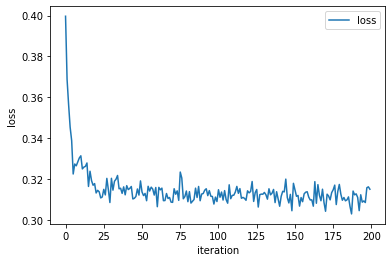

Target optimal controller
[[ 0.06613945  2.82031465 -0.02225431  2.20999893]]
Policy gradient controller
[[ 0.06536644  2.7850757  -0.02523202  2.2181487 ]]
2-norm of controller error:  0.03629971650284931
Spec rad of UNdiscounted linearized system with OPT controller:  1.0105116335655304
post-optimization cost from evaluation:  0.3177829
Spectral radius of UNdiscounted closed-loop:  1.010521796739379
Cost on undiscounted system (empirical):  nan
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.7894615083932877
	trying discount  0.9698816999533981 , cost:  2.253275
	trying discount  0.9548225499300971 , cost:  0.58287126
	trying discount  0.9623521249417476 , cost:  0.98006725
	trying discount  0.9585873374359224 , cost:  0.72469383

Iteration  5 , initial discount  0.9585873374359224
pre-cost from evaluation:  0.7397014
Target optimal cost:  0.5576169112643198
Running policy gradient...
Final cost  0.5736584067344666


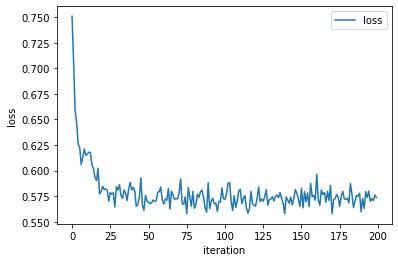

Target optimal controller
[[-0.05074469  4.0731488  -0.55948265  3.2862412 ]]
Policy gradient controller
[[-0.04962638  4.0442324  -0.56163484  3.3145375 ]]
2-norm of controller error:  0.040530533685559804
Spec rad of UNdiscounted linearized system with OPT controller:  0.9904552205352438
post-optimization cost from evaluation:  0.5652118
Spectral radius of UNdiscounted closed-loop:  0.991911844403995
Cost on undiscounted system (empirical):  13.174516
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  1.412573754787445
	trying discount  0.9792936687179612 , cost:  1.5720015

Iteration  6 , initial discount  0.9792936687179612
pre-cost from evaluation:  1.595843
Target optimal cost:  1.1291415519039087
Running policy gradient...
Final cost  1.1616039276123047


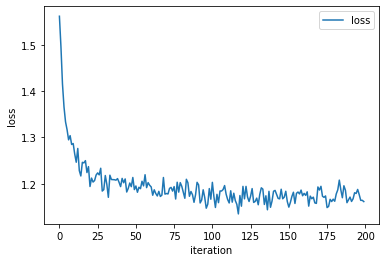

Target optimal controller
[[-0.34174232  6.07872548 -1.71204029  5.12910293]]
Policy gradient controller
[[-0.31410864  5.8052244  -1.5640764   4.725489  ]]
2-norm of controller error:  0.5102586055021449
Spec rad of UNdiscounted linearized system with OPT controller:  0.982476655302741
post-optimization cost from evaluation:  1.1571202
Spectral radius of UNdiscounted closed-loop:  0.9836413941230733
Cost on undiscounted system (empirical):  3.0587263
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  2.9497092962265015
	trying discount  0.9896468343589806 , cost:  1.7815285
	trying discount  0.9948234171794903 , cost:  2.3385952
	trying discount  0.9974117085897451 , cost:  2.7093225

Iteration  7 , initial discount  0.9974117085897451
pre-cost from evaluation:  2.6642773
Target optimal cost:  2.0756373809243125
Running policy gradient...
Final cost  2.1915366649627686


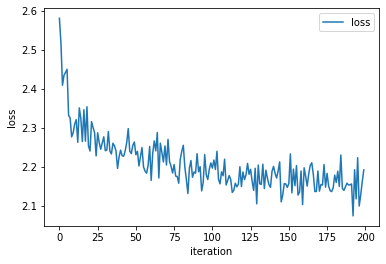

Target optimal controller
[[-0.81070697  8.47929801 -3.36059965  7.44339939]]
Policy gradient controller
[[-0.68371856  7.674296   -2.796945    6.290827  ]]
2-norm of controller error:  1.5199620000933716
Spec rad of UNdiscounted linearized system with OPT controller:  0.9745413577439076
post-optimization cost from evaluation:  2.1893435
Spectral radius of UNdiscounted closed-loop:  0.9796067375171734
Cost on undiscounted system (empirical):  2.3714075
J(1) <  2.5 .J(discount) so good enough

Iteration  8 , initial discount  1
pre-cost from evaluation:  2.3705895
Stabilizing controller found on iteration  8
Doing the final policy gradient update
Target optimal cost:  2.2603976787439977
Running policy gradient...
Final cost  2.3448801040649414


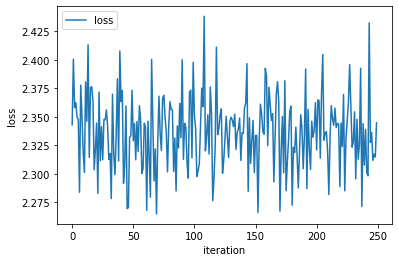

Target optimal controller
[[-0.89970166  8.87862239 -3.65393646  7.835545  ]]
Policy gradient controller
[[-0.8816077  8.869005  -3.6202133  7.8369017]]
2-norm of controller error:  0.039483855083890226
Spec rad of UNdiscounted linearized system with OPT controller:  0.9732870857688721
post-optimization cost from evaluation:  2.3392305
Spectral radius of UNdiscounted closed-loop:  0.9737020202710736
Cost on undiscounted system (empirical):  2.3749456
J(1) <  2.5 .J(discount) so good enough

total time:  3880.915231539999
lwr:  0.3 upr:  0.8
rad:  0.55 cost:  8.5763235
lwr:  0.55 upr:  0.8
rad:  0.675 cost:  14.670103
lwr:  0.675 upr:  0.8
rad:  0.7375 cost:  nan
lwr:  0.675 upr:  0.7375
rad:  0.70625 cost:  16.925568
lwr:  0.70625 upr:  0.7375
rad:  0.721875 cost:  nan
lwr:  0.70625 upr:  0.721875
rad:  0.7140625 cost:  nan
lwr:  0.70625 upr:  0.7140625
rad:  0.71015625 cost:  16.943312
lwr:  0.71015625 upr:  0.7140625
rad:  0.712109375 cost:  nan
lwr:  0.71015625 upr:  0.712109375
rad

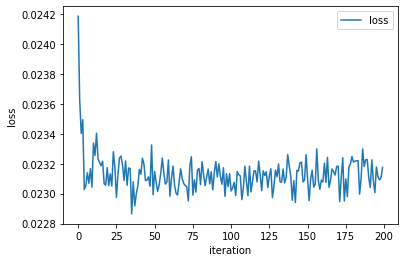

Target optimal controller
[[0.02692094 0.15734008 0.17111459 0.20121149]]
Policy gradient controller
[[0.02690061 0.14841332 0.17036547 0.19991037]]
2-norm of controller error:  0.00905215681678181
Spec rad of UNdiscounted linearized system with OPT controller:  1.0615300805007644
post-optimization cost from evaluation:  0.023285812
Spectral radius of UNdiscounted closed-loop:  1.061712335710436
Cost on undiscounted system (empirical):  2568100.5
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.057945866137742996
	trying discount  0.8857735583417765 , cost:  0.575303
	trying discount  0.8286603375126647 , cost:  0.037534367
	trying discount  0.8572169479272206 , cost:  0.060960587

Iteration  1 , initial discount  0.8572169479272206
pre-cost from evaluation:  0.061377134
Target optimal cost:  0.05235989463688556
Running policy gradient...
Final cost  0.051061440259218216


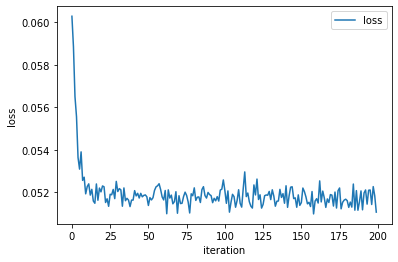

Target optimal controller
[[0.07156047 0.5578161  0.28440931 0.49647784]]
Policy gradient controller
[[0.07117535 0.5294118  0.2837594  0.49456695]]
2-norm of controller error:  0.02847853073412897
Spec rad of UNdiscounted linearized system with OPT controller:  1.0491516800608056
post-optimization cost from evaluation:  0.05225143
Spectral radius of UNdiscounted closed-loop:  1.0496254144100179
Cost on undiscounted system (empirical):  5247565.5
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.12969717383384705
	trying discount  0.9286084739636102 , cost:  151.84668
	trying discount  0.8929127109454154 , cost:  0.13254353

Iteration  2 , initial discount  0.8929127109454154
pre-cost from evaluation:  0.13220693
Target optimal cost:  0.0976675370746611
Running policy gradient...
Final cost  0.09618958830833435


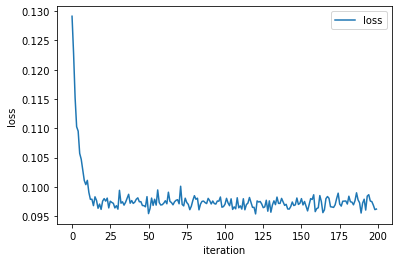

Target optimal controller
[[0.10047046 1.12960651 0.30953934 0.90391817]]
Policy gradient controller
[[0.09535488 1.0881985  0.30358562 0.9002655 ]]
2-norm of controller error:  0.042303403554063077
Spec rad of UNdiscounted linearized system with OPT controller:  1.0360205637729063
post-optimization cost from evaluation:  0.0972585
Spectral radius of UNdiscounted closed-loop:  1.036493847126198
Cost on undiscounted system (empirical):  6509830.0
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.2384701371192932
	trying discount  0.9464563554727077 , cost:  2142.1123
	trying discount  0.9196845332090615 , cost:  0.2644004

Iteration  3 , initial discount  0.9196845332090615
pre-cost from evaluation:  0.26804224
Target optimal cost:  0.17789201902372398
Running policy gradient...
Final cost  0.181643545627594


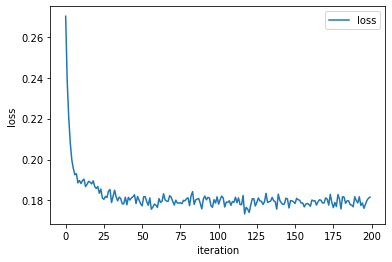

Target optimal controller
[[0.1047231  1.91664053 0.22193753 1.48940264]]
Policy gradient controller
[[0.10041911 1.8697197  0.21027178 1.4806638 ]]
2-norm of controller error:  0.0493208107991837
Spec rad of UNdiscounted linearized system with OPT controller:  1.022636922674921
post-optimization cost from evaluation:  0.18067336
Spectral radius of UNdiscounted closed-loop:  1.0227556903355886
Cost on undiscounted system (empirical):  25074780.0
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.4439721629023552
	trying discount  0.9598422666045308 , cost:  781.66895
	trying discount  0.9397633999067961 , cost:  0.3943667

Iteration  4 , initial discount  0.9397633999067961
pre-cost from evaluation:  0.39914545
Target optimal cost:  0.30651796763081096
Running policy gradient...
Final cost  0.32020068168640137


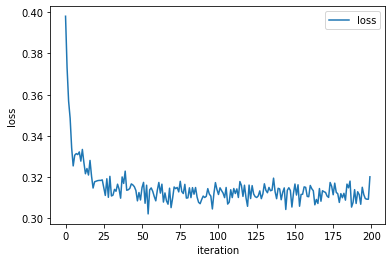

Target optimal controller
[[ 0.06613945  2.82031465 -0.02225431  2.20999893]]
Policy gradient controller
[[ 0.06538311  2.7851667  -0.02525209  2.218274  ]]
2-norm of controller error:  0.0362410420996578
Spec rad of UNdiscounted linearized system with OPT controller:  1.0105116335655304
post-optimization cost from evaluation:  0.30989575
Spectral radius of UNdiscounted closed-loop:  1.0105222671519434
Cost on undiscounted system (empirical):  nan
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.7944001257419586
	trying discount  0.9698816999533981 , cost:  2.2355964
	trying discount  0.9548225499300971 , cost:  0.58178896
	trying discount  0.9623521249417476 , cost:  0.978428
	trying discount  0.9585873374359224 , cost:  0.7488537

Iteration  5 , initial discount  0.9585873374359224
pre-cost from evaluation:  0.739129
Target optimal cost:  0.5576169112643198
Running policy gradient...
Final cost  0.568397045135498


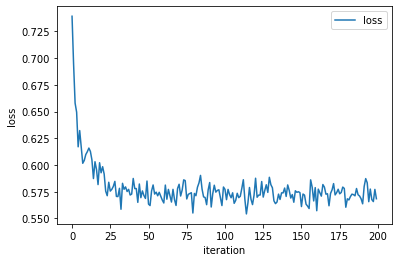

Target optimal controller
[[-0.05074469  4.0731488  -0.55948265  3.2862412 ]]
Policy gradient controller
[[-0.04969994  4.0444484  -0.5614674   3.3144894 ]]
2-norm of controller error:  0.04033241290435039
Spec rad of UNdiscounted linearized system with OPT controller:  0.9904552205352438
post-optimization cost from evaluation:  0.57479316
Spectral radius of UNdiscounted closed-loop:  0.99186651257309
Cost on undiscounted system (empirical):  13.188734
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  1.414453387260437
	trying discount  0.9792936687179612 , cost:  1.5725645

Iteration  6 , initial discount  0.9792936687179612
pre-cost from evaluation:  1.5933237
Target optimal cost:  1.1291415519039087
Running policy gradient...
Final cost  1.1411371231079102


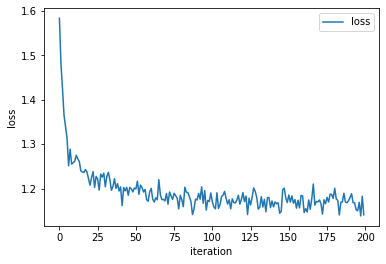

Target optimal controller
[[-0.34174232  6.07872548 -1.71204029  5.12910293]]
Policy gradient controller
[[-0.31407535  5.805144   -1.5636048   4.724857  ]]
2-norm of controller error:  0.5109406525202129
Spec rad of UNdiscounted linearized system with OPT controller:  0.982476655302741
post-optimization cost from evaluation:  1.1644138
Spectral radius of UNdiscounted closed-loop:  0.983656747697569
Cost on undiscounted system (empirical):  3.0464764
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  2.9228848218917847
	trying discount  0.9896468343589806 , cost:  1.7654473
	trying discount  0.9948234171794903 , cost:  2.3061535
	trying discount  0.9974117085897451 , cost:  2.640475

Iteration  7 , initial discount  0.9974117085897451
pre-cost from evaluation:  2.6122482
Target optimal cost:  2.0756373809243125
Running policy gradient...
Final cost  2.153764486312866


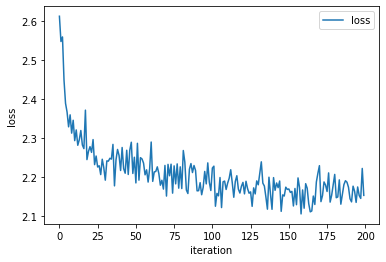

Target optimal controller
[[-0.81070697  8.47929801 -3.36059965  7.44339939]]
Policy gradient controller
[[-0.68301004  7.670043   -2.7928727   6.282223  ]]
2-norm of controller error:  1.5303085304156567
Spec rad of UNdiscounted linearized system with OPT controller:  0.9745413577439076
post-optimization cost from evaluation:  2.1986554
Spectral radius of UNdiscounted closed-loop:  0.9796582940918496
Cost on undiscounted system (empirical):  2.382525
J(1) <  2.5 .J(discount) so good enough

Iteration  8 , initial discount  1
pre-cost from evaluation:  2.4506862
Stabilizing controller found on iteration  8
Doing the final policy gradient update
Target optimal cost:  2.2603976787439977
Running policy gradient...
Final cost  2.323767900466919


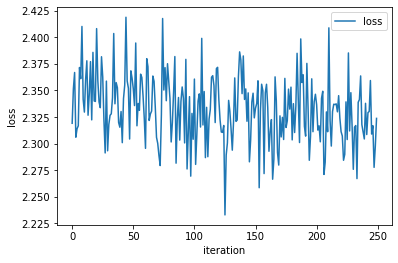

Target optimal controller
[[-0.89970166  8.87862239 -3.65393646  7.835545  ]]
Policy gradient controller
[[-0.88116485  8.86989    -3.6200705   7.8366117 ]]
2-norm of controller error:  0.03959681612413048
Spec rad of UNdiscounted linearized system with OPT controller:  0.9732870857688721
post-optimization cost from evaluation:  2.266539
Spectral radius of UNdiscounted closed-loop:  0.973723520008291
Cost on undiscounted system (empirical):  2.3211887
J(1) <  2.5 .J(discount) so good enough

total time:  3874.3153560200008
lwr:  0.3 upr:  0.8
rad:  0.55 cost:  8.547336
lwr:  0.55 upr:  0.8
rad:  0.675 cost:  14.574154
lwr:  0.675 upr:  0.8
rad:  0.7375 cost:  nan
lwr:  0.675 upr:  0.7375
rad:  0.70625 cost:  16.927443
lwr:  0.70625 upr:  0.7375
rad:  0.721875 cost:  nan
lwr:  0.70625 upr:  0.721875
rad:  0.7140625 cost:  nan
lwr:  0.70625 upr:  0.7140625
rad:  0.71015625 cost:  16.99702
lwr:  0.71015625 upr:  0.7140625
rad:  0.712109375 cost:  nan
lwr:  0.71015625 upr:  0.712109375
rad

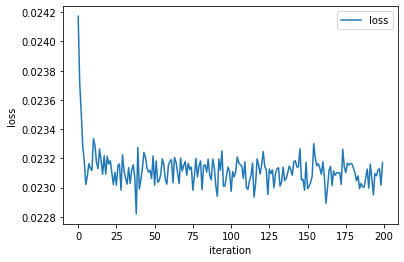

Target optimal controller
[[0.02692094 0.15734008 0.17111459 0.20121149]]
Policy gradient controller
[[0.0267533  0.14852001 0.1703615  0.19981115]]
2-norm of controller error:  0.008963804707673191
Spec rad of UNdiscounted linearized system with OPT controller:  1.0615300805007644
post-optimization cost from evaluation:  0.023146564
Spectral radius of UNdiscounted closed-loop:  1.0617134781965907
Cost on undiscounted system (empirical):  2589767.5
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.05780043080449104
	trying discount  0.8857735583417765 , cost:  0.5768363
	trying discount  0.8286603375126647 , cost:  0.037343837
	trying discount  0.8572169479272206 , cost:  0.059983213

Iteration  1 , initial discount  0.8572169479272206
pre-cost from evaluation:  0.06038627
Target optimal cost:  0.05235989463688556
Running policy gradient...
Final cost  0.051913462579250336


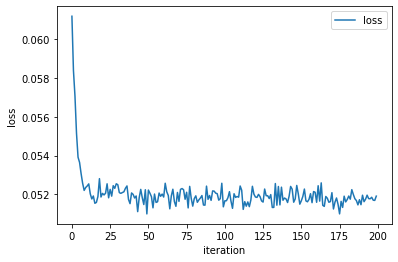

Target optimal controller
[[0.07156047 0.5578161  0.28440931 0.49647784]]
Policy gradient controller
[[0.07121079 0.5292753  0.2837474  0.49461818]]
2-norm of controller error:  0.02861111533505108
Spec rad of UNdiscounted linearized system with OPT controller:  1.0491516800608056
post-optimization cost from evaluation:  0.051993094
Spectral radius of UNdiscounted closed-loop:  1.049626759453494
Cost on undiscounted system (empirical):  5234428.0
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.12916254810988903
	trying discount  0.9286084739636102 , cost:  152.42012
	trying discount  0.8929127109454154 , cost:  0.13302746

Iteration  2 , initial discount  0.8929127109454154
pre-cost from evaluation:  0.13356659
Target optimal cost:  0.0976675370746611
Running policy gradient...
Final cost  0.09567613154649734


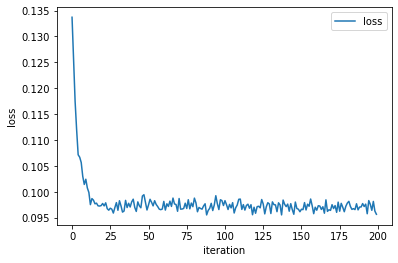

Target optimal controller
[[0.10047046 1.12960651 0.30953934 0.90391817]]
Policy gradient controller
[[0.09504988 1.08794    0.3039239  0.900737  ]]
2-norm of controller error:  0.04251042258714008
Spec rad of UNdiscounted linearized system with OPT controller:  1.0360205637729063
post-optimization cost from evaluation:  0.09790704
Spectral radius of UNdiscounted closed-loop:  1.036492014188262
Cost on undiscounted system (empirical):  6529830.0
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.24210430681705475
	trying discount  0.9464563554727077 , cost:  2149.04
	trying discount  0.9196845332090615 , cost:  0.26743317

Iteration  3 , initial discount  0.9196845332090615
pre-cost from evaluation:  0.2726969
Target optimal cost:  0.17789201902372398
Running policy gradient...
Final cost  0.18037830293178558


Target optimal controller
[[0.1047231  1.91664053 0.22193753 1.48940264]]
Policy gradient controller
[[0.100447   1.8696772  0.21024968 1.4806691 ]]
2-norm of controller error:  0.04936315370701797
Spec rad of UNdiscounted linearized system with OPT controller:  1.022636922674921
post-optimization cost from evaluation:  0.17792085
Spectral radius of UNdiscounted closed-loop:  1.0227566331376492
Cost on undiscounted system (empirical):  25093990.0
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.451241135597229
	trying discount  0.9598422666045308 , cost:  781.2001
	trying discount  0.9397633999067961 , cost:  0.40045205

Iteration  4 , initial discount  0.9397633999067961
pre-cost from evaluation:  0.39358175
Target optimal cost:  0.30651796763081096
Running policy gradient...
Final cost  0.31515753269195557


Target optimal controller
[[ 0.06613945  2.82031465 -0.02225431  2.20999893]]
Policy gradient controller
[[ 0.06532433  2.7851956  -0.02512955  2.2183993 ]]
2-norm of controller error:  0.036233216926162146
Spec rad of UNdiscounted linearized system with OPT controller:  1.0105116335655304
post-optimization cost from evaluation:  0.31213012
Spectral radius of UNdiscounted closed-loop:  1.010519879773619
Cost on undiscounted system (empirical):  nan
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.7787656784057617
	trying discount  0.9698816999533981 , cost:  2.2234566
	trying discount  0.9548225499300971 , cost:  0.5658438
	trying discount  0.9623521249417476 , cost:  0.97197944
	trying discount  0.9585873374359224 , cost:  0.7448952

Iteration  5 , initial discount  0.9585873374359224
pre-cost from evaluation:  0.7393481
Target optimal cost:  0.5576169112643198
Running policy gradient...
Final cost  0.5757287740707397


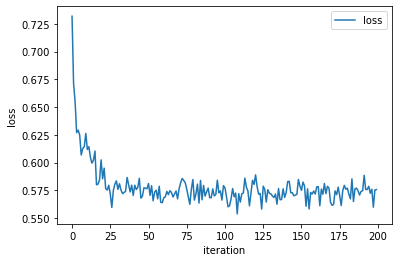

Target optimal controller
[[-0.05074469  4.0731488  -0.55948265  3.2862412 ]]
Policy gradient controller
[[-0.04981807  4.045298   -0.56136847  3.3151224 ]]
2-norm of controller error:  0.040177080465638025
Spec rad of UNdiscounted linearized system with OPT controller:  0.9904552205352438
post-optimization cost from evaluation:  0.57709014
Spectral radius of UNdiscounted closed-loop:  0.99179963395671
Cost on undiscounted system (empirical):  13.110498
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  1.4292292296886444
	trying discount  0.9792936687179612 , cost:  1.5822291

Iteration  6 , initial discount  0.9792936687179612
pre-cost from evaluation:  1.5900881
Target optimal cost:  1.1291415519039087
Running policy gradient...
Final cost  1.1523371934890747


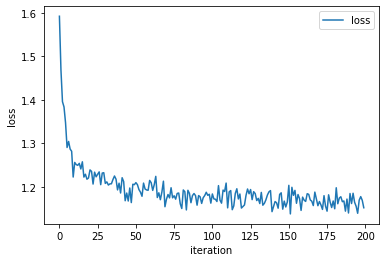

Target optimal controller
[[-0.34174232  6.07872548 -1.71204029  5.12910293]]
Policy gradient controller
[[-0.31405824  5.8047733  -1.5637605   4.724943  ]]
2-norm of controller error:  0.5110266075032368
Spec rad of UNdiscounted linearized system with OPT controller:  0.982476655302741
post-optimization cost from evaluation:  1.1876144
Spectral radius of UNdiscounted closed-loop:  0.9836451839875838
Cost on undiscounted system (empirical):  3.0927749
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  2.9560115933418274
	trying discount  0.9896468343589806 , cost:  1.7811238
	trying discount  0.9948234171794903 , cost:  2.298084
	trying discount  0.9974117085897451 , cost:  2.60668

Iteration  7 , initial discount  0.9974117085897451
pre-cost from evaluation:  2.6481242
Target optimal cost:  2.0756373809243125
Running policy gradient...
Final cost  2.1321804523468018


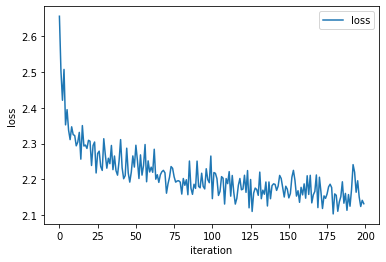

Target optimal controller
[[-0.81070697  8.47929801 -3.36059965  7.44339939]]
Policy gradient controller
[[-0.68319154  7.6731663  -2.795677    6.2882214 ]]
2-norm of controller error:  1.5230503922219711
Spec rad of UNdiscounted linearized system with OPT controller:  0.9745413577439076
post-optimization cost from evaluation:  2.174416
Spectral radius of UNdiscounted closed-loop:  0.9796232961529016
Cost on undiscounted system (empirical):  2.354639
J(1) <  2.5 .J(discount) so good enough

Iteration  8 , initial discount  1
pre-cost from evaluation:  2.3457332
Stabilizing controller found on iteration  8
Doing the final policy gradient update
Target optimal cost:  2.2603976787439977
Running policy gradient...
Final cost  2.26393985748291


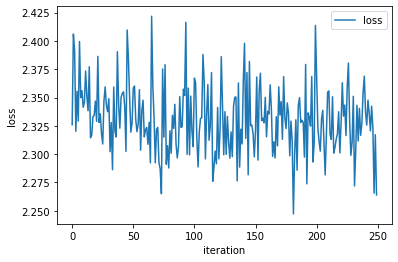

Target optimal controller
[[-0.89970166  8.87862239 -3.65393646  7.835545  ]]
Policy gradient controller
[[-0.8819851  8.869479  -3.6202383  7.836466 ]]
2-norm of controller error:  0.03916486874562048
Spec rad of UNdiscounted linearized system with OPT controller:  0.9732870857688721
post-optimization cost from evaluation:  2.3379629
Spectral radius of UNdiscounted closed-loop:  0.9737277220202402
Cost on undiscounted system (empirical):  2.3368304
J(1) <  2.5 .J(discount) so good enough

total time:  3842.1479768690006
lwr:  0.3 upr:  0.8
rad:  0.55 cost:  8.442638
lwr:  0.55 upr:  0.8
rad:  0.675 cost:  14.921775
lwr:  0.675 upr:  0.8
rad:  0.7375 cost:  nan
lwr:  0.675 upr:  0.7375
rad:  0.70625 cost:  16.965883
lwr:  0.70625 upr:  0.7375
rad:  0.721875 cost:  nan
lwr:  0.70625 upr:  0.721875
rad:  0.7140625 cost:  nan
lwr:  0.70625 upr:  0.7140625
rad:  0.71015625 cost:  17.334288
lwr:  0.71015625 upr:  0.7140625
rad:  0.712109375 cost:  17.186527
lwr:  0.712109375 upr:  0.7140625

Target optimal controller
[[0.02692094 0.15734008 0.17111459 0.20121149]]
Policy gradient controller
[[0.02698728 0.14853069 0.17039509 0.199858  ]]
2-norm of controller error:  0.008941994272199362
Spec rad of UNdiscounted linearized system with OPT controller:  1.0615300805007644
post-optimization cost from evaluation:  0.02304406
Spectral radius of UNdiscounted closed-loop:  1.0617107402219637
Cost on undiscounted system (empirical):  2562046.8
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.05779956001788378
	trying discount  0.8857735583417765 , cost:  0.56990105
	trying discount  0.8286603375126647 , cost:  0.03739192
	trying discount  0.8572169479272206 , cost:  0.060564145

Iteration  1 , initial discount  0.8572169479272206
pre-cost from evaluation:  0.061334293
Target optimal cost:  0.05235989463688556
Running policy gradient...
Final cost  0.05216091126203537


Target optimal controller
[[0.07156047 0.5578161  0.28440931 0.49647784]]
Policy gradient controller
[[0.07137182 0.5291302  0.28346592 0.49449682]]
2-norm of controller error:  0.02877028852433421
Spec rad of UNdiscounted linearized system with OPT controller:  1.0491516800608056
post-optimization cost from evaluation:  0.051497154
Spectral radius of UNdiscounted closed-loop:  1.0496308845029487
Cost on undiscounted system (empirical):  5234691.0
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.12947652488946915
	trying discount  0.9286084739636102 , cost:  152.05678
	trying discount  0.8929127109454154 , cost:  0.1314343

Iteration  2 , initial discount  0.8929127109454154
pre-cost from evaluation:  0.13153058
Target optimal cost:  0.0976675370746611
Running policy gradient...
Final cost  0.09776881337165833


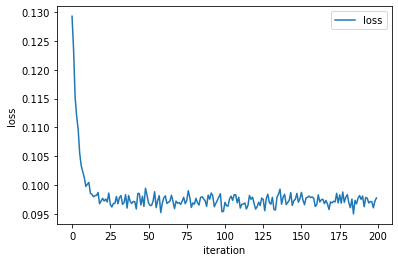

Target optimal controller
[[0.10047046 1.12960651 0.30953934 0.90391817]]
Policy gradient controller
[[0.09563625 1.0882044  0.30344653 0.900412  ]]
2-norm of controller error:  0.042271993366402374
Spec rad of UNdiscounted linearized system with OPT controller:  1.0360205637729063
post-optimization cost from evaluation:  0.09638098
Spectral radius of UNdiscounted closed-loop:  1.0364944508593064
Cost on undiscounted system (empirical):  6523931.0
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.2459624968469143
	trying discount  0.9464563554727077 , cost:  2128.624
	trying discount  0.9196845332090615 , cost:  0.2663103

Iteration  3 , initial discount  0.9196845332090615
pre-cost from evaluation:  0.26356247
Target optimal cost:  0.17789201902372398
Running policy gradient...
Final cost  0.17733073234558105


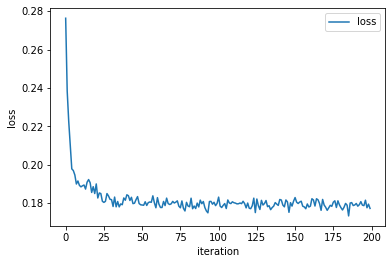

Target optimal controller
[[0.1047231  1.91664053 0.22193753 1.48940264]]
Policy gradient controller
[[0.10059545 1.8692713  0.20981766 1.4802895 ]]
2-norm of controller error:  0.04990816610310785
Spec rad of UNdiscounted linearized system with OPT controller:  1.022636922674921
post-optimization cost from evaluation:  0.1778144
Spectral radius of UNdiscounted closed-loop:  1.0227600641252366
Cost on undiscounted system (empirical):  25239362.0
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.4469915106892586
	trying discount  0.9598422666045308 , cost:  784.32336
	trying discount  0.9397633999067961 , cost:  0.39686728

Iteration  4 , initial discount  0.9397633999067961
pre-cost from evaluation:  0.40068555
Target optimal cost:  0.30651796763081096
Running policy gradient...
Final cost  0.30854475498199463


Target optimal controller
[[ 0.06613945  2.82031465 -0.02225431  2.20999893]]
Policy gradient controller
[[ 0.06543307  2.7848854  -0.02538787  2.2182982 ]]
2-norm of controller error:  0.03652981557280128
Spec rad of UNdiscounted linearized system with OPT controller:  1.0105116335655304
post-optimization cost from evaluation:  0.31273273
Spectral radius of UNdiscounted closed-loop:  1.0105245613394196
Cost on undiscounted system (empirical):  nan
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  0.7801748067140579
	trying discount  0.9698816999533981 , cost:  2.236325
	trying discount  0.9548225499300971 , cost:  0.57946324
	trying discount  0.9623521249417476 , cost:  0.98041797
	trying discount  0.9585873374359224 , cost:  0.7311156

Iteration  5 , initial discount  0.9585873374359224
pre-cost from evaluation:  0.7363834
Target optimal cost:  0.5576169112643198
Running policy gradient...
Final cost  0.5682814121246338


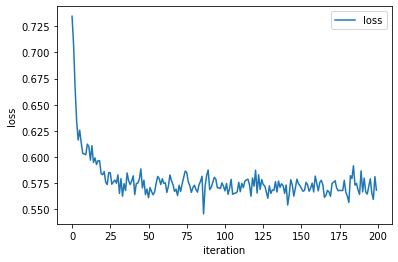

Target optimal controller
[[-0.05074469  4.0731488  -0.55948265  3.2862412 ]]
Policy gradient controller
[[-0.04970542  4.0446205  -0.5614335   3.3145802 ]]
2-norm of controller error:  0.0402721695260604
Spec rad of UNdiscounted linearized system with OPT controller:  0.9904552205352438
post-optimization cost from evaluation:  0.58071387
Spectral radius of UNdiscounted closed-loop:  0.9918599733267295
Cost on undiscounted system (empirical):  13.099404
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  1.4605700969696045
	trying discount  0.9792936687179612 , cost:  1.581065

Iteration  6 , initial discount  0.9792936687179612
pre-cost from evaluation:  1.5296805
Target optimal cost:  1.1291415519039087
Running policy gradient...
Final cost  1.1652648448944092


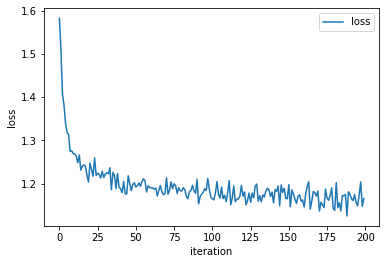

Target optimal controller
[[-0.34174232  6.07872548 -1.71204029  5.12910293]]
Policy gradient controller
[[-0.3139705  5.8026967 -1.5625321  4.7218895]]
2-norm of controller error:  0.5149161523841141
Spec rad of UNdiscounted linearized system with OPT controller:  0.982476655302741
post-optimization cost from evaluation:  1.1717802
Spectral radius of UNdiscounted closed-loop:  0.9836612717393743
Cost on undiscounted system (empirical):  3.0494907
Controller does NOT stabilize undiscounted system. Doing binary search...
	target cost:  2.9177290201187134
	trying discount  0.9896468343589806 , cost:  1.762723
	trying discount  0.9948234171794903 , cost:  2.2842655
	trying discount  0.9974117085897451 , cost:  2.6182315

Iteration  7 , initial discount  0.9974117085897451
pre-cost from evaluation:  2.6228704
Target optimal cost:  2.0756373809243125
Running policy gradient...
Final cost  2.1851041316986084


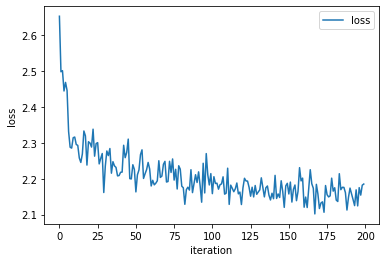

Target optimal controller
[[-0.81070697  8.47929801 -3.36059965  7.44339939]]
Policy gradient controller
[[-0.68298584  7.668423   -2.7918766   6.280671  ]]
2-norm of controller error:  1.5327144767658487
Spec rad of UNdiscounted linearized system with OPT controller:  0.9745413577439076
post-optimization cost from evaluation:  2.098067
Spectral radius of UNdiscounted closed-loop:  0.9796616197431108
Cost on undiscounted system (empirical):  2.3456867
J(1) <  2.5 .J(discount) so good enough

Iteration  8 , initial discount  1
pre-cost from evaluation:  2.3706129
Stabilizing controller found on iteration  8
Doing the final policy gradient update
Target optimal cost:  2.2603976787439977
Running policy gradient...
Final cost  2.289402484893799


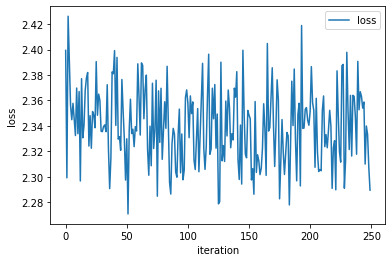

Target optimal controller
[[-0.89970166  8.87862239 -3.65393646  7.835545  ]]
Policy gradient controller
[[-0.8812301  8.868714  -3.6200678  7.8366723]]
2-norm of controller error:  0.039846224509316706
Spec rad of UNdiscounted linearized system with OPT controller:  0.9732870857688721
post-optimization cost from evaluation:  2.3378067
Spectral radius of UNdiscounted closed-loop:  0.9736926578044803
Cost on undiscounted system (empirical):  2.2974656
J(1) <  2.5 .J(discount) so good enough

total time:  3856.953040881999
lwr:  0.3 upr:  0.8
rad:  0.55 cost:  8.603984
lwr:  0.55 upr:  0.8
rad:  0.675 cost:  14.342782
lwr:  0.675 upr:  0.8
rad:  0.7375 cost:  nan
lwr:  0.675 upr:  0.7375
rad:  0.70625 cost:  16.708649
lwr:  0.70625 upr:  0.7375
rad:  0.721875 cost:  nan
lwr:  0.70625 upr:  0.721875
rad:  0.7140625 cost:  nan
lwr:  0.70625 upr:  0.7140625
rad:  0.71015625 cost:  17.50004
lwr:  0.71015625 upr:  0.7140625
rad:  0.712109375 cost:  17.656456
lwr:  0.712109375 upr:  0.7140625


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
radii = [0.1,0.3,0.5,0.6,0.7]
num_reps = 5
max_iters = 30

discounts = np.zeros((len(radii),num_reps,max_iters))
pre_costs = np.zeros((len(radii),num_reps,max_iters))
post_costs = np.zeros((len(radii),num_reps,max_iters))
Kerrors = np.zeros((len(radii),num_reps,max_iters))
roas = np.zeros((len(radii),num_reps))

print('Sample time: ', dt)

# create a representative system (for storage)
demo_sys = cp = MyCartPole(Q_cuda, R_cuda, dt, ball_radius=1).cuda()

# use linearization for initial discount
discount = 0.9/(np.linalg.norm(Alcp,2)**2)
print('Initial discount factor ', discount)

results = {
    "system": demo_sys,
    "radii": radii,
    "num_reps": num_reps,
    "discounts": discounts,
    "pre_costs": pre_costs,
    "post_costs": post_costs,
    "Kerrors": Kerrors,
    "roas": roas,
}


for [radius_index, ball_radius] in enumerate(radii):

  for rep in range(num_reps):
    print('\n---------------------------')
    print('Ball radius: ', ball_radius, ' , rep: ', rep)

    cp = MyCartPole(Q_cuda, R_cuda, dt, ball_radius).cuda()

    # hack: add the linearization
    cp.Alin = Alcp
    cp.Blin = Blcp

    try:
      ds,p_cs,c_ps,ks = model_free_stabilization_opt(discount, 
                                           cp,
                                           num_rollouts=5000,
                                           rollout_length=1000,
                                           num_policy_gradient_iters=200,
                                           learning_rate=0.01/ball_radius,
                                           max_iters=max_iters) 
      
      # compute the roa for the final controller
      roa = compute_roa_ball(1, cp)  

    except:
      print('\n***WARNING: some kind of failure!!!***\n')
      ds = np.nan*np.ones(max_iters)
      p_cs = np.nan*np.ones(max_iters)
      c_ps = np.nan*np.ones(max_iters)
      ks = np.nan*np.ones(max_iters)
      roa = np.nan

    # store results
    discounts[radius_index,rep,:] = ds
    pre_costs[radius_index,rep,:] = p_cs
    post_costs[radius_index,rep,:] = c_ps
    Kerrors[radius_index,rep,:] = ks
    roas[radius_index, rep] = roa

    results["discounts"] = discounts
    results["pre_costs"] = pre_costs
    results["post_costs"] = post_costs
    results["Kerrors"] = Kerrors
    results["roas"] = roas

    # save as we go (in case of crash)
    fname = "radii_results.pkl"
    with open(fname, "wb") as fid:
        pkl.dump(results, fid, protocol=pkl.HIGHEST_PROTOCOL)

# download at the end
files.download(fname) 




  


# Plots

Code to produce tables and plots in the paper.

**Warning:** datasets not included, so the code will not run.

## region of attraction

In [ ]:
# provide filename of results
file_name = "..."

with open(file_name, "rb") as fid:
    results = pkl.load(fid)

print(results.keys())

for rad_index, radius in enumerate(results['radii']):

  roas = results['roas'][rad_index]

  print('radius: ', radius)
  print('all: ', roas)
  print( 
      'min: ', round(np.min(roas),3), 
      'med: ', round(np.median(roas),3),
      'max: ', round(np.max(roas),3))   

dict_keys(['system', 'radii', 'num_reps', 'discounts', 'costs', 'roas'])
radius:  0.1
all:  [0.70292969 0.70292969 0.70292969]
min:  0.703 med:  0.703 max:  0.703
radius:  0.3
all:  [0.71015625 0.70820313 0.70820313]
min:  0.708 med:  0.708 max:  0.71
radius:  0.5
all:  [0.7109375 0.715625  0.7109375]
min:  0.711 med:  0.711 max:  0.716
radius:  0.7
all:  [0.76875 0.7     0.76875]
min:  0.7 med:  0.769 max:  0.769


## policy error vs discount

In [ ]:
# provide filename of results
file_name = "..."

with open(file_name, "rb") as fid:
    results = pkl.load(fid)

rad_i = 2
rep = 1
roa = results["roas"][rad_i,rep]
ds = results["discounts"][rad_i,rep,:]
ks = results["Kerrors"][rad_i,rep,:]

cs = results["post_costs"][rad_i,rep,:]

print('pst costs:', cs[0:10])
print('roa: ', roa)

# provide filename of results
file_name = "..."

with open(file_name, "rb") as fid:
    results = pkl.load(fid)

# results["roas"][1]
dss = results["discounts"]
kss = results["Kerrors"]

plt.figure()
plt.semilogy(ds[0:9],ks[0:9], label='r=0.7')
plt.semilogy(dss[0:9],kss[0:9], label='r=0.05')
plt.xlabel('discount, $\gamma$', fontsize=14)
plt.ylabel('$|| K_{pg}^* - K_{lin}^* ||_F$', fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig('err_vs_discount')



pst costs: [ 0.12356497  0.27148938  0.51914448  0.90769374  1.71025968  2.92901897
  5.47887039 10.73701572 15.41839695  0.        ]
roa:  0.7757812500000001
